# Obesity treatment prediction
Author - Danilov Sergey

## Libraries load

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import datetime
import pickle
from datetime import datetime
from matplotlib import pyplot as plt
import graphviz
import os

# ML
from sklearn.decomposition import PCA
from sklearn.experimental import enable_iterative_imputer, enable_halving_search_cv
from sklearn.model_selection import train_test_split, learning_curve, LearningCurveDisplay, LeaveOneOut, KFold, GridSearchCV, HalvingGridSearchCV
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression, Lars, Ridge, Lasso, LogisticRegression
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score, mean_absolute_error, make_scorer, accuracy_score, classification_report, ConfusionMatrixDisplay, f1_score, precision_score, recall_score, accuracy_score, roc_auc_score, jaccard_score, average_precision_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer
from sklearn.impute import KNNImputer, SimpleImputer, IterativeImputer
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from sklearn.svm import SVR, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.inspection import permutation_importance

# from fedot.api.main import Fedot

# Stats
from scipy.stats import kstest, norm, spearmanr, pearsonr, chi2_contingency, chisquare, fisher_exact, barnard_exact, ks_2samp, ttest_ind, mannwhitneyu
import shap
from xgboost import XGBClassifier, XGBRegressor

# Setups
import warnings
warnings.filterwarnings("ignore")
generate_path = lambda m: f"model_{m.__class__.__name__}_{datetime.now().strftime('%d_%m_%y')}.pkl"
pd.options.display.float_format = '{:,.4f}'.format
from contextlib import suppress


/var/folders/l6/jwssjpj12nj3dzpx8mx0f9hc0000gp/T/ipykernel_9413/193532998.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
def prepare_dir(name):
  import os
  if not os.path.exists(name):
    os.mkdir(name)
  else:
    import shutil
    shutil.rmtree(name)
    os.mkdir(name)

## Data Load

Загружаем датасет Алмазова

In [4]:
dataset_path = "data/dataset_almazov_november.xlsx"
if (not os.path.exists(dataset_path)):
  !gdown 1G3-HmI67zesBYZadd2khZLc3EMLgy9Se -O dataset_almazov_november.xlsx
full_dataset = pd.read_excel(dataset_path)
dataset = full_dataset.copy()
dataset.head(5)

,ID,"Пол 0 - М, 1 - Ж","Выполняли ли ПЭТ 0- нет, 1 - да","Наличие БЖТ исходно по ПЭТ 0 -нет, 1 - да","Наличие БЖТ через 6 мес по ПЭТ 0 -нет, 1 - да",Возраст,Рост,Вес 0 мес,Вес 3 мес,Вес 6 мес,...,Ограничительное (Диетическое) пищевое поведение В2.,Насколько голодным вы себя чувствуете? В2.,Насколько сытым вы себя чувствуете? В2.,Насколько сильно вы хотите есть? В2.,Сколько пищи вы могли бы сейчас съесть? В2.,Никотин В2.,Алкоголь В2.,EQ-5 В2.,Депрессия В1..1,Тревога В2.
0,SIB001,1,1,0.0000,NaN,39,160,101.0000,101.0000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,SIB002,1,1,1.0000,0.0000,47,167,100.0000,90.0000,90.0000,...,2.8000,2.0000,7.0000,2.0000,5.0000,0.0000,2.0000,70.0000,5.0000,9.0000
2,SIB003,1,1,0.0000,0.0000,44,164,89.0000,78.0000,80.0000,...,3.8000,3.0000,7.0000,2.0000,2.0000,0.0000,2.0000,70.0000,0.0000,3.0000
3,SIB004,0,1,0.0000,0.0000,31,178,124.0000,115.0000,109.0000,...,3.4000,2.0000,8.0000,2.0000,1.0000,7.0000,1.0000,45.0000,14.0000,10.0000
4,SIB005,1,1,0.0000,1.0000,30,161,102.0000,98.0000,96.0000,...,3.6000,0.0000,8.0000,0.0000,0.0000,0.0000,6.0000,90.0000,0.0000,3.0000


In [62]:
dataset.shape

(121, 313)

In [64]:
pd.read_excel("data/dataset_september.xlsx").shape

(125, 313)

In [5]:
if not os.path.exists("ttests"):
  os.mkdir("ttests")
prepare_dir("chisquare")
prepare_dir("correlation")

## Preproceeesing

Было решено соединить методы лечения VBD STD в общую STD как метод лечения диетой

In [6]:
def read_params_list_from_stattests(folder_path):
    params_lists = {
        "SIB": [],
        "SAX": [],
        "STD": []
    }
    
    for m in list(params_lists.keys()):
        path = os.path.join(folder_path, f"{m}_params.txt")
        with open(path, "r", encoding="utf-8") as f:
            content = f.read().replace('"', '').replace(',','')
            params_lists[m] = content.split("\n")
            with suppress(ValueError, AttributeError):
                params_lists[m].remove('')
    return params_lists

params_list = read_params_list_from_stattests("stattests_result/params_lists")

In [7]:
medicines = {
    'STD': 'Диета',
    'SIB': 'Сибутрамин',
    'SAX': 'Лираглутид'
}

parameters_truncated = {
    'Глюкоза крови натощак ммоль/л (3,3-6,1) 0 мес': "Глюкоза",
    'Пол 0 - М, 1 - Ж': 'Пол',
    'Степень Ожир': 'Степень ожирения',
    'Инсулин пкмоль/л (17.80 - 173.00) перемножить 6,945 0 мес': 'Инсулин',
    'Индекс HOMA-IR (> 3) 0 мес': 'HOMA-IR',
    'Индекс HOMA-В (20×инсулин плазмы натощак (мкЕд/мл)/глюкозы плазмы натощак (ммоль/л)-3,5 ) 0 мес': 'HOMA-B',
    'ОХС ммоль/л (3,5-5,0) 0 мес': 'OXC',
    'Мочевая кислота ммоль/л (0.14 - 0.34) 0 мес': 'Мочевая Кислота',
    'ЛПВП ммоль/л (Ж >1.20, М>1.0) 0 мес': 'ЛПВП',
    'ЛПНП ммоль/л (<3.00) 0 мес': 'ЛПНП',
    'ТГ ммоль/л (<1.77) 0 мес': 'ТГ',
    'КА (0-3,5) 0 мес': 'КА',
    'С-РБ мг/л (0-6) 0 мес': 'СРБ',
    'Эмоциональное пищевое поведение В1.': 'Эмоциональное ПП',
    'Экстернальное пищевое поведение В1.': 'Экстернальное ПП',
    'Ограничительное (Диетическое) пищевое поведение В1.': 'Диетическое ПП',
    'Насколько голодным вы себя чувствуете? В1.': 'Голод',
    'Насколько сытым вы себя чувствуете? В1.': 'Сытость',
    'Насколько сильно вы хотите есть? В1.': 'Степень желания поесть',
    'Сколько пищи вы могли бы сейчас съесть? В1.': "Сколько может сьесть",
    'EQ-5 В1.': 'EQ-5',
    'Депрессия В1.': 'Депрессия',
    'Тревога В1.': 'Тревога',
    'НТГ (нарушнгин толерантности к глюкозе)': 'НТГ',
    'МЗО=0/МНО=1 V3 (Мейгц)': 'МЗО/МНО_V3',
    'Стаж ожирения (1 - до 5 лет, 2 5-10 лет, 3 - более 10 лет': 'Стаж ожирения',
    'Фенотип ожирения - 0 - Центральное ожирение, 1 - Периферическое ожирение, более 0,9 у мужчин и 0,85 у женщин – центральное ожиренрие, менее периферическое': 'Фенотип ожирения',
    'Артериальная гипертензия': 'Артериальная гипертензия',
    'Дислипидемия': 'Дислипидемия'
}

parameters = [
    'Лечение',
    'Пол',
    'Возраст',
    'Рост',
    'Степень ожирения',
    'Стаж ожирения',
    'САД',
    'ДАД',
    'Пульс',
    'Глюкоза',
    'Инсулин',
    'HOMA-IR',
    'HOMA-B',
    'OXC',
    'Мочевая Кислота',
    'ЛПВП',
    'ЛПНП',
    'ТГ',
    'КА',
    'СРБ',
    'Вес 0 мес',
    'ОТ 0 мес',
    'ОБ 0 мес',
    'ОТ/ОБ 0 мес',
    'ИМТ 0 мес',
    'Эмоциональное ПП',
    'Экстернальное ПП',
    'Диетическое ПП',
    'Голод',
    'Сытость',
    'Степень желания поесть',
    'Сколько может сьесть',
    'EQ-5',
    'Депрессия',
    'Тревога',
    'НТГ',
    'Артериальная гипертензия',
    'Дислипидемия',
    'Фенотип ожирения',
    'МЗО/МНО_V3']


initial_columns = [
    'Вес 0 мес',
    'ОТ 0 мес',
    'ОБ 0 мес',
    'ОТ/ОБ 0 мес',
    'ИМТ 0 мес'
]

targets = [
    '% потери веса 3 мес',
    '% потери веса 6 мес',
    'Вес 3 мес',
    'Вес 6 мес',
    'ОТ 3 мес',
    'ОТ/ОБ 3 мес',
    'ОТ/ОБ 6 мес',
    'ОТ 6 мес',
    'ОБ 3 мес',
    'ОБ 6 мес'
]

medicine_keys = [
    "SIB",
    "STD",
    "SAX"
]

discret_params = ['НТГ',
      'Голод',
      'МЗО/МНО_V3',
      'Степень ожирения',
      'Тревога',
      'Пол',
      'Артериальная гипертензия',
      'Депрессия',
      'Сколько может сьесть',
      'Степень желания поесть',
      'Дислипидемия',
      'Экстернальное ПП',
      'Эмоциональное ПП',
      'Диетическое ПП',
      'Стаж ожирения',
      'Фенотип ожирения',
      'Сытость']

categorical_param = [
    'Пол',
    'Артериальная гипертензия',
    'Дислипидемия',
    'Фенотип ожирения'
]

percent_targets = [
    '% потери веса 3 мес',
    '% потери веса 6 мес'
]

weigth_target = [
    'Вес 3 мес',
    'Вес 6 мес'
]

continious_cols = ["Глюкоза",
        "ЛПНП",
        "Инсулин",
        "ЛПВП",
        "HOMA-IR",
        "КА",
        "СРБ",
        "HOMA-B",
        "Мочевая Кислота",
        "OXC"]

discret_params = ["Тип ПП 0 - нет нарушений, 1 - эмоциогенное, 2 - экстернальное, 3 - ограничительное",
                  "ГПП-1 после нагрузки 0 - норма и выше, 1 снижение","В-Блокаторы", "МЗО=0/МНО=1",
                  "Стаж ожирения", "Степень ожирения", "Пол", "Нарушение экстернального ПП 0 - нет, 1 - да",
                  "Кардиогруппа 0 - стадия А (норма), 1 - ОЛП/рост2 повышен, 2 - ММЛЖ/рост2,7 повышен, 3 - ОЛП и ММЛЖ повышены",
                  "Лептинрезистентность 0 - повышение лептина, 1 - снижение лептина, 2 - лептин не изменялся", "Сартаны",
                  "Дислипидемия", "Артериальная гипертензия"]

agroup_parameters = list(set(initial_columns+parameters+targets))


In [8]:
dataset["Лечение"] = dataset["ID"].apply(lambda x: x[:3])
dataset.loc[dataset["Лечение"]=="VBD", "Лечение"] = "STD"
    set = dataset.drop((dataset[dataset["Лечение"]=="Red"]).index)
dataset = dataset.drop("ID", axis=1)

dataset.columns = list(map(lambda x: x.strip(), dataset.columns))
dataset.columns = list(map(lambda x: " ".join(x.split()), dataset.columns))
dataset.columns = list(map(lambda i: parameters_truncated[i] if i in parameters_truncated else i, dataset.columns))

dataset["% потери веса 3 мес"] = (((dataset["Вес 0 мес"]-dataset["Вес 3 мес"])/dataset["Вес 0 мес"]))*100
dataset["% потери веса 6 мес"] = (((dataset["Вес 0 мес"]-dataset["Вес 6 мес"])/dataset["Вес 0 мес"]))*100
dataset[dataset["ИМТ 0 мес"].isna()]["ИМТ 0 мес"] = (dataset[dataset["ИМТ 0 мес"].isna()]["Вес 0 мес"]
                                                     / dataset[dataset["ИМТ 0 мес"].isna()]["Рост"]**2).round()
dataset = dataset.loc[~pd.isna(dataset['Вес 3 мес']) | ~pd.isna(dataset['Вес 6 мес'])]
errors = ["101,,3", "1,87,54", "0,,38"]
cols = dataset.columns[(dataset.isin(errors)).any()]
for col in cols:
  dataset.loc[dataset[col]=="101,,3", col] = 101.3
  dataset.loc[dataset[col]=="1,87,54", col] = 1.8754
  dataset.loc[dataset[col]=="0,,38", col] = 0.38
dataset["Мочевая Кислота"] = dataset["Мочевая Кислота"].astype(float)

## Анализ распределения колонок через хи-квадрат

In [32]:

aliases = {
    "A": "% изменения веса за 3 мес",
    "B": "% изменения веса за 6 мес",
    'C': "% макс изменения веса за 3 и 6 мес",
    'D': "% изменения веса больше и за 3 и за 6 мес"
}

def add_descriptions(df, condition_column="Условие"):
  for i in list(aliases.keys()):
    df.loc[df[condition_column]==i, condition_column] = aliases[i]

def get_conditions(dataset_x, threshold=5):
  conditions = {
      "A": (dataset_x["% потери веса 3 мес"]>=threshold),
      "B": (dataset_x[~pd.isna(dataset_x["% потери веса 6 мес"])]["% потери веса 6 мес"]>=threshold),
      'C': (np.nanmax(dataset_x[["% потери веса 3 мес","% потери веса 6 мес"]], axis=1)>=threshold),
      'D': (dataset_x["% потери веса 3 мес"]>=threshold)&(dataset_x["% потери веса 6 мес"]>=threshold)
  }
  return conditions

In [33]:
def test_chisquare(medicine="SAX"):
  global dataset
  dataset_x = dataset.copy()
  stats = []
  for i in range(5,  15):
    for j in ["A", "B", "C", "D"]:
      conditions = get_conditions(dataset_x, threshold=i)
      dataset_x["success"] = conditions[j]
      dataset_x = dataset_x[dataset_x["Лечение"]==medicine]
      for col in dataset_x.columns:
        if ((col == "success") or (col not in discret_params)):
          continue
        res = [col, f"{i}%", aliases[j], None, None]
        if any([col.find(prf)!=-1 for prf in ["3 мес", "6 мес", "В2", "Респондер", "В.2", "В1..1", "ПЭТ"]]):
          continue
        if ((~(dataset_x[col].isna())).sum() < 20):
          continue
        try:
          A = dataset_x.pivot_table(columns=col, index="success", aggfunc="size").fillna(0)
        except:
          raise Exception(f"{col} cannot be calculated")
        try:
          res[3]=chi2_contingency(A)[1]
        except Exception as e:
          pass
        try:
          res[4]=fisher_exact(A)[1]
        except Exception as e:
          pass
        res.append((~(dataset_x[col].isna())).sum())
        stats.append(res)
  dfds = pd.DataFrame(stats, columns=["Параметр", 'Порог %', 'Условие', "p-value chisquare", "p-value fisher", "Количество"])
  dfds = dfds[((~(dfds["p-value chisquare"].isna()))&(dfds["p-value chisquare"]<=0.05))|((~(dfds["p-value fisher"].isna()))&(dfds["p-value fisher"]<=0.05))].reset_index(drop=True)
  return dfds


In [34]:
sax_df = test_chisquare("SAX")
sax_df = sax_df[sax_df["Параметр"].isin(discret_params)]
sax_df

,Параметр,Порог %,Условие,p-value chisquare,p-value fisher,Количество
0,Степень ожирения,5%,% изменения веса за 6 мес,0.0353,NaN,27
1,Сартаны,5%,% макс изменения веса за 3 и 6 мес,0.0400,0.0369,27
2,Степень ожирения,6%,% изменения веса за 6 мес,0.0353,NaN,27
3,Сартаны,6%,% макс изменения веса за 3 и 6 мес,0.0400,0.0369,27
4,Степень ожирения,7%,% изменения веса за 6 мес,0.0194,NaN,27
5,Сартаны,7%,% макс изменения веса за 3 и 6 мес,0.0767,0.0461,27
7,Степень ожирения,8%,% изменения веса за 6 мес,0.0194,NaN,27
8,Сартаны,8%,% макс изменения веса за 3 и 6 мес,0.0767,0.0461,27


In [35]:
sib_df = test_chisquare("SIB")
sib_df = sib_df[sib_df["Параметр"].isin(discret_params)]
sib_df

,Параметр,Порог %,Условие,p-value chisquare,p-value fisher,Количество
1,"Кардиогруппа 0 - стадия А (норма), 1 - ОЛП/рос...",5%,% изменения веса за 6 мес,0.0029,NaN,34
3,"Кардиогруппа 0 - стадия А (норма), 1 - ОЛП/рос...",5%,% изменения веса больше и за 3 и за 6 мес,0.0112,NaN,34
4,"Кардиогруппа 0 - стадия А (норма), 1 - ОЛП/рос...",6%,% изменения веса за 3 мес,0.0390,NaN,34
6,"Кардиогруппа 0 - стадия А (норма), 1 - ОЛП/рос...",6%,% изменения веса за 6 мес,0.0243,NaN,34
8,"Кардиогруппа 0 - стадия А (норма), 1 - ОЛП/рос...",6%,% макс изменения веса за 3 и 6 мес,0.0282,NaN,34
9,"Кардиогруппа 0 - стадия А (норма), 1 - ОЛП/рос...",6%,% изменения веса больше и за 3 и за 6 мес,0.0413,NaN,34
11,"Кардиогруппа 0 - стадия А (норма), 1 - ОЛП/рос...",7%,% изменения веса за 6 мес,0.0113,NaN,34
12,"Лептинрезистентность 0 - повышение лептина, 1 ...",7%,% изменения веса за 6 мес,0.0141,NaN,63
13,"Кардиогруппа 0 - стадия А (норма), 1 - ОЛП/рос...",7%,% макс изменения веса за 3 и 6 мес,0.0368,NaN,34
14,"Кардиогруппа 0 - стадия А (норма), 1 - ОЛП/рос...",7%,% изменения веса больше и за 3 и за 6 мес,0.0413,NaN,34


In [14]:
std_df = test_chisquare("STD")
std_df = std_df[std_df["Параметр"].isin(discret_params)]
std_df

,param,treshold,condition,p-value chisquare,p-value fisher


In [36]:
std_df.to_csv("chisquare/STD_chisquare.csv")
sib_df.to_csv("chisquare/SIB_chisquare.csv")
sax_df.to_csv("chisquare/SAX_chisquare.csv")

### Тест Колмогорова-Смирнова, Мэнни-Витни и Стьюдента для непрерывных величин

Проводит тест Колмогорова-Смирнова для непрерывных величин чтобы понять, различается ли распределение непрерывных величин при удачном и неудачном лечении Сибутрамином

In [37]:
def test_distributions(medicine="SIB"):
  dcolsnunique = dataset.nunique()
  dcolsnunique = dcolsnunique[dcolsnunique<5].index.values
  dataset_x = dataset.copy()
  dataset_x = dataset_x[dataset_x["Лечение"]==medicine]
  stats = []
  for i in range(5, 15):
    for c in ["A", "B", "C", "D"]:
      conditions = get_conditions(dataset_x, threshold=i)
      dataset_x["success"] = conditions[c]
      for p in dataset_x.columns:
        if (p == "success"):
          continue
        param_not_none = dataset_x[~dataset_x[p].isna()]
        if (param_not_none.shape[0] < 10):
          continue
        if any([p.find(prf)!=-1 for prf in ["3 мес", "6 мес", "В2", "Респондер", "В.2", "В1..1", "ПЭТ"]]) or p in dcolsnunique:
          continue
        param_from_fail = param_not_none[param_not_none["success"]==0][p]
        param_from_succ = param_not_none[param_not_none["success"]==1][p]
        try:
          mw_result = mannwhitneyu(param_from_fail, param_from_succ)
        except:
          mw_result = [1, 1]
        try:
          ttest_result = ttest_ind(param_from_fail, param_from_succ)
        except:
          ttest_result = [1, 1]
        stats.append([p, f"{i}%", aliases[c], mw_result[1], ttest_result[1], param_from_succ.mean(), param_from_succ.std(), param_from_fail.mean(), param_from_fail.std(ddof=0), param_not_none.shape[0]])
  ks_stats = pd.DataFrame(stats, columns=["Параметр", 'Порог %', 'Условие', "MW p-value", "t-test p_value", '+ mean', '+ std', '- mean', '- std', "Количество сэмплов"]).round(2)
  ks_stats = ks_stats[((~(ks_stats["MW p-value"].isna()))&(ks_stats["MW p-value"]<=0.05))|((~(ks_stats["t-test p_value"].isna()))&(ks_stats["t-test p_value"]<=0.05))].reset_index(drop=True)

  return ks_stats

In [38]:
sib_ttest_df = test_distributions("SIB")
sib_ttest_df

,Параметр,Порог %,Условие,MW p-value,t-test p_value,+ mean,+ std,- mean,- std,Количество сэмплов
0,ДАД,5%,% изменения веса за 3 мес,0.0900,0.0500,74.5100,9.8000,70.3900,8.7500,79
1,ГПП 1 нг/мл 0 мес,5%,% изменения веса за 3 мес,0.0200,0.0200,3.2300,1.3800,3.9500,1.0200,66
2,Грелин 1 час (нг/мл) 0 мес.1,5%,% изменения веса за 3 мес,0.0400,0.0300,4.7000,3.6500,10.6900,9.9800,35
3,miR378 (ПЖТ) 0 мес,5%,% изменения веса за 3 мес,0.0100,0.0100,"1,635.6200","1,376.7000","4,174.3700","2,174.1100",27
4,miR155 0 мес,5%,% изменения веса за 3 мес,0.0200,0.0100,"6,420.7300","5,270.2400","16,444.6000","5,330.6700",13
...,...,...,...,...,...,...,...,...,...,...
454,"КСО, мл, 0 мес",14%,% изменения веса больше и за 3 и за 6 мес,0.1000,0.0000,74.0000,NaN,40.2700,8.6500,34
455,"УО, мл, 0 мес",14%,% изменения веса больше и за 3 и за 6 мес,0.1000,0.0000,96.0000,NaN,64.9300,9.1500,31
456,"ММЛЖ/ (рост, м)^2,7 0 мес",14%,% изменения веса больше и за 3 и за 6 мес,0.1000,0.0000,77.4700,NaN,47.8600,8.7200,34
457,"ММЛЖ/ (рост, м) 0 мес",14%,% изменения веса больше и за 3 и за 6 мес,0.1000,0.0000,194.7700,NaN,112.3100,18.7800,34


In [ ]:
sib_ttest_df[(sib_ttest_df["Порог %"] == ">5%") & (sib_ttest_df["Условие"].isin(["A", "C"]))]

,Параметр,Порог %,Условие,MW p-value,t-test p_value,+ mean,+ std,- mean,- std,count
0,ДАД,>5%,A,0.0500,0.0300,74.8200,9.7700,70.2400,8.7100,79
1,ГПП 1 нг/мл 0 мес,>5%,A,0.0200,0.0200,3.2200,1.4000,3.9400,1.0100,66
2,Грелин 1 час (нг/мл) 0 мес.1,>5%,A,0.0400,0.0300,4.7000,3.6500,10.6900,9.9800,35
3,miR378 (ПЖТ) 0 мес,>5%,A,0.0100,0.0100,"1,635.6200","1,376.7000","4,174.3700","2,174.1100",27
4,miR155 0 мес,>5%,A,0.0200,0.0100,"6,420.7300","5,270.2400","16,444.6000","5,330.6700",13
5,Миелопероксидаза нг/мл (˂200) 0 мес,>5%,A,0.0500,0.4800,80.4200,119.7500,106.2100,113.6900,44
6,Проколлаген 1 типа нг/мл (183-244) 0 мес,>5%,A,0.2100,0.0400,75.7300,31.5000,127.0300,98.1400,44
9,miR142 (ПЛАЗМА) 0 мес,>5%,C,0.0200,0.1800,"76,070.1200","116,029.8800","38,606.0500","52,742.5300",50


In [ ]:
sax_ttest_df = test_distributions("SAX")
sax_ttest_df

,Параметр,Порог %,Условие,MW p-value,t-test p_value,+ mean,+ std,- mean,- std,count
0,Креатинин мкмоль/л (53-106) 0 мес,>5%,A,0.0100,0.0200,66.2700,8.9000,76.3100,10.2300,27
1,ГПП 1 нг/мл 0 мес,>5%,A,0.1000,0.0500,5.3900,3.9600,3.0000,1.6600,25
2,"Грелин АС Рассчет на коэффициент (нг/мл) К=3,4...",>5%,A,0.0100,0.0100,7.7700,5.2800,2.0800,1.0500,14
3,CCL2 0 мес,>5%,A,0.0200,0.2200,"4,726.6300","3,101.5900","69,597.2300","110,335.9900",12
4,NT-proBMP пг/мл (<85.80) 0 мес,>5%,A,0.0300,0.0200,94.3000,66.8800,32.0500,21.3600,16
...,...,...,...,...,...,...,...,...,...,...
250,"Грелин АС Рассчет на коэффициент (нг/мл) К=3,4...",>14%,C,0.2900,0.0300,13.5600,NaN,3.8300,3.6300,14
251,"TAVS, см/с, 0 мес",>14%,C,0.0700,0.0400,11.0000,1.4100,13.3200,1.3800,21
252,ММЛЖ/КДО 0 мес,>14%,C,0.0600,0.0100,2.5600,0.5100,1.9200,0.3000,21
253,"DP mmHg, 0 мес",>14%,C,0.1600,0.0400,94.0000,NaN,77.6700,5.9600,10


In [ ]:
std_ttest_df = test_distributions("STD")
std_ttest_df

,Параметр,Порог %,Условие,MW p-value,t-test p_value,+ mean,+ std,- mean,- std,count
0,Возраст,>5%,A,0.0200,0.0100,31.1700,9.9300,47.1100,9.9500,15
1,Рост,>5%,A,0.0200,0.0000,177.3300,9.7500,162.1100,6.6700,15
2,(ОТ (см) к росту (см2))*1000 (ООТР) 0 мес,>5%,A,0.0300,0.0200,3.3100,0.5300,3.9500,0.3600,15
3,Инсулин,>5%,A,0.0000,0.0000,73.5400,35.8800,159.4900,49.9500,15
4,HOMA-IR,>5%,A,0.0100,0.0100,2.4400,1.2700,5.6300,2.2300,15
...,...,...,...,...,...,...,...,...,...,...
217,Мочевая Кислота,>14%,C,0.1300,0.0100,0.6900,NaN,0.3600,0.1000,15
218,Грелин (нг/мл) 0 мес,>14%,C,0.1300,0.0300,9.6300,NaN,3.6900,2.3200,15
219,"Грелин АС Рассчет на коэффициент (нг/мл) К=3,4...",>14%,C,0.1300,0.0500,33.6400,NaN,11.4800,9.4000,15
220,Экстернальное ПП,>14%,C,0.2000,0.0400,2.1000,NaN,3.2300,0.4600,15


In [ ]:
sax_ttest_df.to_csv("ttests/SAX_ttest.csv")
sib_ttest_df.to_csv("ttests/SIB_ttest.csv")
std_ttest_df.to_csv("ttests/STD_ttest.csv")

### Корреляции Спирмана и Пирсона между параметрами и таргетом

In [ ]:
if ("success" in dataset.columns):
  dataset = dataset.drop(["success"], axis=1)

In [ ]:
from scipy import stats
def pearsonr_test(x, y):
  dcolsnunique = dataset.nunique()
  dcolsnunique = dcolsnunique[dcolsnunique<5].index.values
  x = x.loc[:, ~x.isna().all()]
  f = []
  for p in x.columns:
    mask = ~(x[p].isna())
    param_not_none = x[mask]
    if (param_not_none.shape[0] < 10):
      continue
    if any([p.find(prf)!=-1 for prf in ["3 мес", "6 мес", "В2", "Респондер", "В.2", "В1..1", "ПЭТ"]]) or (p in dcolsnunique):
      continue
    res = pearsonr(np.array(x[mask][p]), y[mask])
    f.append([p, res[1], res[0]])
  return pd.DataFrame(f, columns=["Parameter", "p-value pearson", "pearsonr"])

In [ ]:
default_params = list(filter(lambda x: x not in categorical_param+["Лечение"]+targets, agroup_parameters))
def spearman_test(x, y):
  dcolsnunique = dataset.nunique()
  dcolsnunique = dcolsnunique[dcolsnunique<5].index.values
  y[:] = SimpleImputer().fit_transform(y.reshape(-1, 1)).reshape(-1)
  f = []
  for p in x.columns:
    mask = ~(x[p].isna())
    param_not_none = x[mask]
    if (param_not_none.shape[0] < 10):
      continue
    if any([p.find(prf)!=-1 for prf in ["3 мес", "6 мес", "В2", "Респондер", "В.2", "В1..1", "ПЭТ"]]) or (p in dcolsnunique):
      continue
    res = spearmanr(np.array(x[mask][p]), y[mask])
    f.append([p, res[1], res[0]])
  return pd.DataFrame(f, columns=["Parameter", "p-value spearman", "spearmanr"])

In [ ]:
def correlation_test(medicine="SIB", condition="A"):
  dataset_x = dataset.copy()
  x = dataset_x[dataset_x["Лечение"]==medicine].drop("Лечение", 1)
  if (condition=="A"):
    y = x["% потери веса 3 мес"].to_numpy()
  if (condition=="B"):
    x = x[~x["% потери веса 6 мес"].isna()]
    y = x["% потери веса 6 мес"].to_numpy()
  if (condition=="C"):
    y = np.nanmax(x[["% потери веса 3 мес", "% потери веса 6 мес"]], axis=1)
  if (condition=="D"):
    y = np.nanmean(x[["% потери веса 3 мес", "% потери веса 6 мес"]], axis=1)
  dfsp = spearman_test(x, y)
  dfp = pearsonr_test(x, y)
  dfsp = dfsp.merge(dfp, on="Parameter", how="left")
  dfsp = dfsp[(dfsp["p-value spearman"]<0.05) | (dfsp["p-value pearson"]<0.05)]
  dfsp.sort_values(by="p-value spearman", ascending=True)
  return dfsp


In [ ]:
for i in ["SIB", "SAX", "STD"]:
  for j in ["A", "B", "C"]:
    dft = correlation_test(medicine=i, condition=j)
    if (j=="A"):
      dft.to_csv(f"correlation/{i}_corr_3percent.csv")
    if (j=="B"):
      dft.to_csv(f"correlation/{i}_corr_6percent.csv")
    if (j=="C"):
      dft.to_csv(f"correlation/{i}_corr_max3and6percent.csv")

Корреляция между колонками - метод ранговой корреляции Спирмана

In [ ]:
# target_col = "% потери веса 3 мес"
# matrix_spearmanr_pvalue = spearman_test(medicine=None)
# matrix_spearmanr_pvalue[target_col] = matrix_spearmanr_pvalue["p-value"]
# matrix_spearmanr = spearman_test(medicine=None)
# matrix_spearmanr[target_col] = matrix_spearmanr["spearmanr"]
# for i in matrix_spearmanr_pvalue["Parameter"]:
#   res = spearman_test(target=i, medicine=None)
#   matrix_spearmanr[i] = res[res["p-value"]<0.05]["spearmanr"]
# matrix_spearmanr = matrix_spearmanr.drop(columns=["p-value", "spearmanr"])
# matrix_spearmanr.fillna("---")


TypeError: ignored

In [ ]:
# target_col = "% потери веса 3 мес"
# matrix_pearsonr_pvalue = pearsonr_test(target=target_col, medicine=None)
# matrix_pearsonr_pvalue[target_col] = matrix_pearsonr_pvalue["p-value"]
# matrix_pearsonr = pearsonr_test(target=target_col, medicine=None)
# matrix_pearsonr[target_col] = matrix_pearsonr["pearsonr"]
# for i in matrix_pearsonr_pvalue["Parameter"]:
#   res = pearsonr_test(target=i, medicine=None)
#   matrix_pearsonr[i] = res[res["p-value"]<0.05]["pearsonr"]
# matrix_pearsonr = matrix_pearsonr.drop(columns=["p-value", "pearsonr"])
# matrix_pearsonr.fillna("-")

## Построение модели

В эксперименте я использую следующие модели:
 - Linear Regression
 - Random Forest
 - Decision Tree
 - SVR
 - Lasso
 - Gradient Boosting Regressor

In [23]:
import pandas as pd
import json

class Dataset:
    def __init__(self, dataset_path):
        self.dataset_path = dataset_path
        self.dataset = pd.read_excel(self.dataset_path)
        with open("data_preprocessing/columns.json", "r", encoding="utf-8") as f:
            self.config = json.load(f)
        

    def preprocess(self, agroup_params_only=True):
        dataset = self.dataset.copy()
        parameters_truncated = self.config["parameters_truncated"]
        columns_list = self.config["all_parameters"]

        dataset.columns = list(map(lambda x: x.strip(), dataset.columns))
        dataset.columns = list(map(lambda x: " ".join(x.split()), dataset.columns))
        dataset = dataset[columns_list]
        
        dataset["Лечение"] = dataset["ID"].apply(lambda x: x[:3])
        dataset.loc[dataset["Лечение"] == "VBD", "Лечение"] = "STD"
        dataset = dataset.drop((dataset[dataset["Лечение"] == "Red"]).index)
        dataset = dataset.drop("ID", axis=1)

        dataset.columns = list(
                        map(lambda i: parameters_truncated[i] if i in parameters_truncated else i, dataset.columns))

        if (agroup_params_only):
            agroup_params = self.config["model_parameters"]
            dataset = dataset[agroup_params]
            
        dataset["% потери веса 3 мес"] = ((dataset["Вес 0 мес"] - dataset["Вес 3 мес"]) / dataset["Вес 0 мес"]) * 100
        dataset["% потери веса 6 мес"] = ((dataset["Вес 0 мес"] - dataset["Вес 6 мес"]) / dataset["Вес 0 мес"]) * 100
        
        dataset[dataset["ИМТ 0 мес"].isna()]["ИМТ 0 мес"] = (dataset[dataset["ИМТ 0 мес"].isna()]["Вес 0 мес"]
                                                             / dataset[dataset["ИМТ 0 мес"].isna()][
                                                                 "Рост"] ** 2).round()
        
        dataset[dataset["ИМТ 3 мес"].isna()]["ИМТ 3 мес"] = (dataset[dataset["ИМТ 3 мес"].isna()]["Вес 3 мес"]
                                                     / dataset[dataset["ИМТ 3 мес"].isna()][
                                                         "Рост"] ** 2).round()
        
        dataset[dataset["ИМТ 6 мес"].isna()]["ИМТ 6 мес"] = (dataset[dataset["ИМТ 6 мес"].isna()]["Вес 6 мес"]
                                                             / dataset[dataset["ИМТ 6 мес"].isna()][
                                                                 "Рост"] ** 2).round()
        
        dataset = dataset.loc[~pd.isna(dataset['Вес 3 мес']) | ~pd.isna(dataset['Вес 6 мес'])]
        errors = ["101,,3", "1,87,54", "0,,38"]
        cols = dataset.columns[(dataset.isin(errors)).any()]
        for col in cols:
            dataset.loc[dataset[col] == "101,,3", col] = 101.3
            dataset.loc[dataset[col] == "1,87,54", col] = 1.8754
            dataset.loc[dataset[col] == "0,,38", col] = 0.38
        dataset["Мочевая Кислота"] = dataset["Мочевая Кислота"].astype(float)

        self.dataset = dataset
        
    
    def get_X_y(self, medicine, treshold=5, params=None, target_type="A"):
        dataset = self.dataset.copy()
        
        dataset = dataset[dataset["Лечение"] == medicine].drop("Лечение", axis=1)
        
        if (target_type=="A"):
            y_target = dataset["% потери веса 3 мес"]
        if (target_type=="B"):
            y_target = dataset["% потери веса 6 мес"]
        if (target_type=="C"):
            targetcol = ["% потери веса 3 мес", "% потери веса 6 мес"]
            y_target = dataset[targetcol].max(numeric_only = True, axis=1)
        
        target = (y_target >= treshold).astype(int).reset_index(drop=True).to_numpy()
        
        X = dataset
        y = target
        
        if params!=None:
            X = dataset[params]
            
        X = X.reset_index(drop=True)
        
        for j in self.config["targets"]:
            if (j in X.columns):
                X = X.drop(j, axis=1)
        
        X = X.astype(float)
        return X, y


In [3]:
def classification_experiment(model, X, y, use_pipeline=True, imputer=None, scaler=None):
  if (use_pipeline):
      pipe = Pipeline([
        ("imputer", imputer),
        ("sclaer", scaler),
        ("model", model)
      ])
  else:
      pipe = model

  cv_loo = LeaveOneOut()
  y_true = []
  y_pred = []
  for idx, (train_index, test_index) in enumerate(cv_loo.split(X)):
    X_train, X_test, y_train, y_test = X.iloc[train_index, :], \
                                      X.iloc[test_index, :], \
                                      y[train_index], \
                                      y[test_index]
    pipe.fit(X_train, y_train)
    y_pred.append(pipe.predict(X_test))
    y_true.append(y_test[0])
  y_pred = np.array(y_pred).squeeze()
  return pipe, X, y_true, y_pred

In [4]:
def permutation_importance_plot(model, X, y_true):
    feature_importance =  model.feature_importances_
    sorted_idx = np.argsort(feature_importance)
    fig = plt.figure(figsize=(12, 6))
    result = permutation_importance(
        model, X, y_true, n_repeats=100
    )
    sorted_idx = result.importances_mean.argsort()
    plt.boxplot(
        result.importances[sorted_idx].T,
        vert=False,
        labels=model.feature_names_in_[sorted_idx],
    )
    plt.title("Permutation Importance")
    plt.show()

In [5]:
def shap_summary_plot(model, X):
    explainer = shap.TreeExplainer(model, X)
    shap_values = explainer(X)
    shap.summary_plot(shap_values[:, :],X)

In [72]:
def get_shap_explainer(model, X):
    explainer = shap.TreeExplainer(model, X)
    return explainer

def shap_sample_explain(explainer, sample):
    shap_values = explainer(sample)
    shap.plots.waterfall(shap_values[1][:, 1])

In [7]:
def experiment_logger(model, X, y_true, y_pred):
    statdf = pd.DataFrame(list(zip(model.feature_names_in_, model.feature_importances_))).sort_values(by=1, ascending=False)
    statdf = statdf[statdf[1]>0.0001]
    print("\n")
    print(classification_report(y_true, y_pred))
    print("\n")
    try:
        print("ROC AUC score: ", roc_auc_score(y_true, y_pred))
    except: 
        pass
    display(statdf)
    display(ConfusionMatrixDisplay.from_predictions(y_true, y_pred))
    permutation_importance_plot(model, X, y_true)
    shap_summary_plot(model, X)

### Эксперименты

In [25]:
dt = Dataset(dataset_path="data/dataset_september.xlsx")
dt.preprocess(agroup_params_only=True)
dt_test = Dataset(dataset_path="data/dataset_almazov_november_test.xlsx")
dt_test.preprocess(agroup_params_only=True)



              precision    recall  f1-score   support

           0       0.71      0.75      0.73        36
           1       0.65      0.61      0.63        28

    accuracy                           0.69        64
   macro avg       0.68      0.68      0.68        64
weighted avg       0.69      0.69      0.69        64



ROC AUC score:  0.6785714285714285


,0,1
1,ДАД,0.4054
4,Глюкоза,0.2198
0,OXC,0.1487
3,СКФ,0.1279
2,Лептин (нг/мл) 0 мес,0.0981


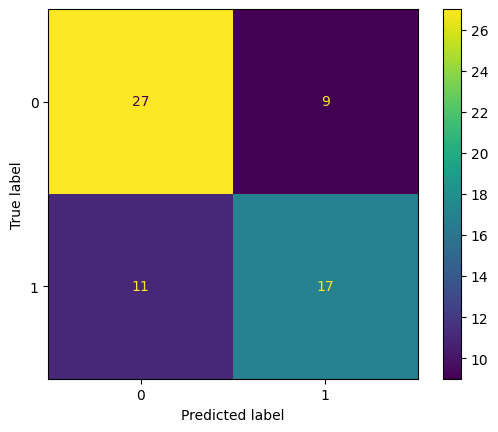

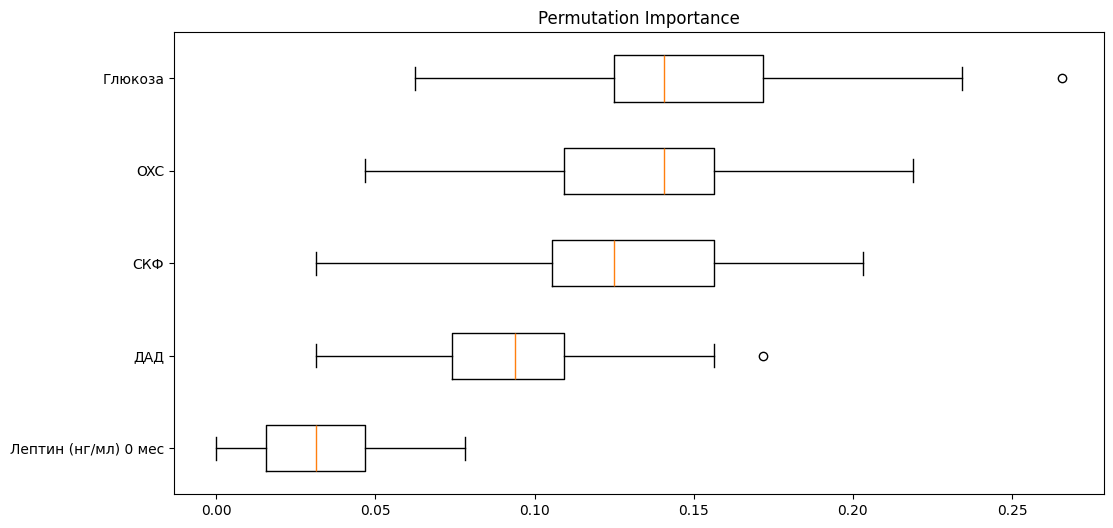

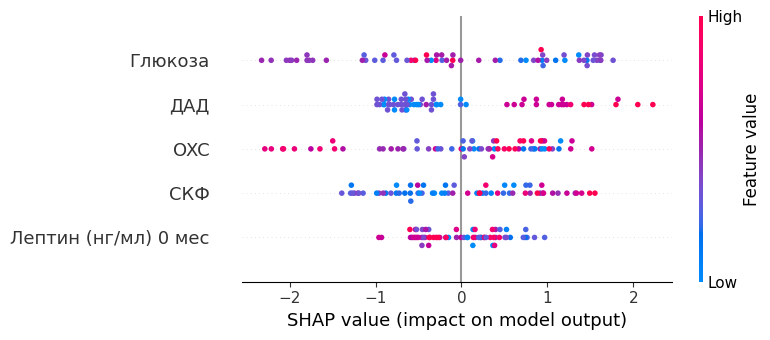

In [108]:
params_good = ["OXC", "ДАД", "Лептин (нг/мл) 0 мес", 'СКФ', 'Глюкоза']
X, y = dt.get_X_y("SIB", 5, params=params_good, target_type="A")
model, X, y_true, y_pred = classification_experiment(XGBClassifier(), X, y, use_pipeline=False)
experiment_logger(model, X, y_true, y_pred)

In [112]:
X.corr()

,OXC,ДАД,Лептин (нг/мл) 0 мес,СКФ,Глюкоза
OXC,1.0000,-0.0038,0.0634,-0.3197,-0.0803
ДАД,-0.0038,1.0000,0.0473,0.0942,0.2395
Лептин (нг/мл) 0 мес,0.0634,0.0473,1.0000,0.0270,0.0218
СКФ,-0.3197,0.0942,0.0270,1.0000,0.0030
Глюкоза,-0.0803,0.2395,0.0218,0.0030,1.0000


SHAP values: 
 .values =
array([[-1.75200151, -0.45714158, -0.32412126,  0.2835578 ,  0.44790327]])

.base_values =
array([-0.604158])

.data =
array([[  5.25,  70.  , 133.5 , 137.94,   4.85]]) 

Real:  0 Predicted:  0


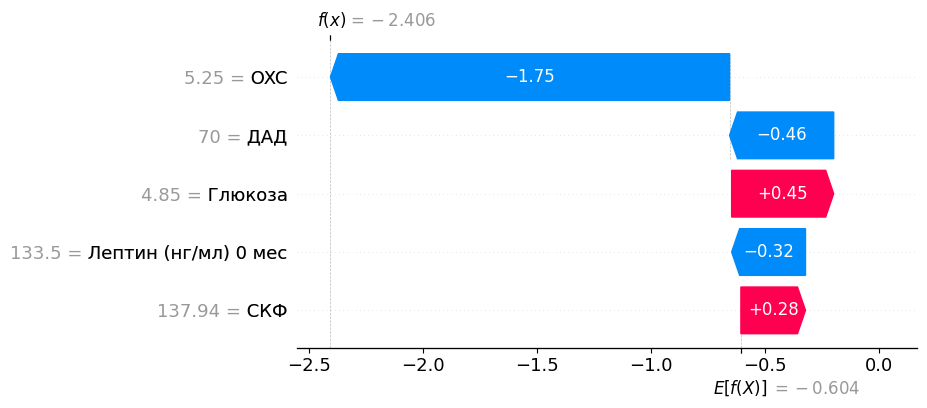

In [111]:
sample_num = 5
exp = get_shap_explainer(model, X)

# shap_sample_explain(exp, X.iloc[0])
shpa_values = exp(X.iloc[sample_num:sample_num+1])
print("SHAP values: \n", shpa_values, "\n")
print("Real: ", y[sample_num], "Predicted: ", model.predict(X.iloc[sample_num:sample_num+1])[0])
shap.plots.waterfall(shpa_values[0])

In [115]:
X.iloc[sample_num].to_dict()

{'OXC': 5.25,
 'ДАД': 70.0,
 'Лептин (нг/мл) 0 мес': 133.5,
 'СКФ': 137.94,
 'Глюкоза': 4.85}

In [113]:
pickle.dump(model, open("model_snapshots/model_xgboost_agroup_20_02.pkl", "wb"))
pickle.dump(exp, open("model_snapshots/explainer_model_xgboost_agroup_20_02.pkl", "wb"))

получили модель с ROC AUC 59%

опробуем модель на новых 15 пациентах

In [37]:
params_good = ["OXC", "ДАД", "Возраст", "Лептин (нг/мл) 0 мес", "Креатинин", "Глюкоза", "ИМТ 0 мес"]
X, y = dt.get_X_y("SIB", 5, params=params_good)
X_test, y_test = dt_test.get_X_y("SIB", 5, params=params_good)
model = XGBClassifier()
model.fit(X, y)
pickle.dump(model, open("model.pkl", "wb"))
y_pred = model.predict(X_test)

print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.50      0.57      0.53         7
           1       0.57      0.50      0.53         8

    accuracy                           0.53        15
   macro avg       0.54      0.54      0.53        15
weighted avg       0.54      0.53      0.53        15



In [39]:
X.iloc[1]

OXC                     4.9000
ДАД                    90.0000
Возраст                47.0000
Лептин (нг/мл) 0 мес   84.8800
Креатинин              82.0000
Глюкоза                 6.9000
Name: 1, dtype: float64

In [68]:
params_good = ["OXC", "ДАД", "Возраст", "Лептин (нг/мл) 0 мес", "Креатинин", "Глюкоза"]
X, y = dt.get_X_y("SIB", 5, params=params_good, target_type="B")
X_test, y_test = dt_test.get_X_y("SIB", 5, params=params_good, target_type="B")
model = XGBClassifier()
model.fit(X, y)
pickle.dump(model, open("model.pkl", "wb"))
y_pred = model.predict(X_test)

print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.56      1.00      0.71         5
           1       1.00      0.60      0.75        10

    accuracy                           0.73        15
   macro avg       0.78      0.80      0.73        15
weighted avg       0.85      0.73      0.74        15



In [70]:
shap


'<script charset=\'utf-8\'>/*! For license information please see bundle.js.LICENSE.txt */\n(()=>{var e={486:function(e,t,n){var r;e=n.nmd(e),function(){var a,i="Expected a function",o="__lodash_hash_undefined__",u="__lodash_placeholder__",l=32,s=128,c=1/0,f=9007199254740991,p=NaN,d=4294967295,h=[["ary",s],["bind",1],["bindKey",2],["curry",8],["curryRight",16],["flip",512],["partial",l],["partialRight",64],["rearg",256]],v="[object Arguments]",g="[object Array]",y="[object Boolean]",m="[object Date]",b="[object Error]",_="[object Function]",w="[object GeneratorFunction]",x="[object Map]",k="[object Number]",S="[object Object]",E="[object Promise]",C="[object RegExp]",T="[object Set]",M="[object String]",N="[object Symbol]",P="[object WeakMap]",z="[object ArrayBuffer]",L="[object DataView]",O="[object Float32Array]",A="[object Float64Array]",F="[object Int8Array]",D="[object Int16Array]",R="[object Int32Array]",j="[object Uint8Array]",U="[object Uint8ClampedArray]",I="[object Uint16Arra

In [59]:
def get_predictions_with_confidence(model, X, y, multi_class=False):
    probs = model.predict_proba(X)
    y_pred, y_test = model.predict(X), y
    data = []
    if (multi_class):
        p = {0: "less 5%", 1: "5% - 10%", 2:"more 10%"}
    else:
        p = {0: "less 5%", 1: "more 5%"}
    for i in range(X_test.shape[0]):
        data.append([p[y_test[i]], p[y_pred[i]], f"{round(probs[i][y_pred[i]]*100, 2) if multi_class==False else probs[i].round(2)}"])
    return pd.DataFrame(data, columns=["Real", "Predicted", "Confidence"])
print("Prediction for new patients")
print(classification_report(y_pred, y_test))
get_predictions_with_confidence(model, X_test, y_test, False)

Prediction for new patients


ValueError: Found input variables with inconsistent numbers of samples: [64, 15]

### 3 bins



              precision    recall  f1-score   support

           0       0.60      0.72      0.66        36
           1       0.35      0.30      0.32        20
           2       0.00      0.00      0.00         8

    accuracy                           0.50        64
   macro avg       0.32      0.34      0.33        64
weighted avg       0.45      0.50      0.47        64





,0,1
3,Лептин (нг/мл) 0 мес,0.2176
1,ДАД,0.2001
5,Глюкоза,0.1789
4,Креатинин,0.1771
0,OXC,0.1739
2,Возраст,0.0523


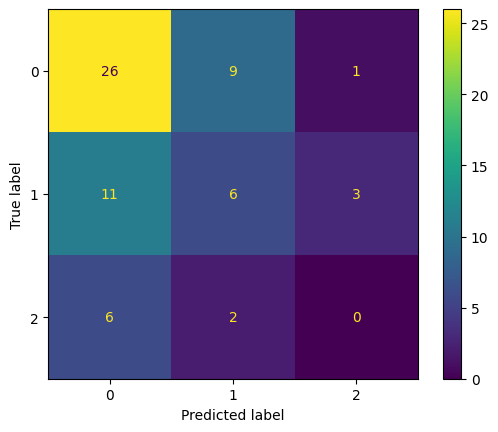

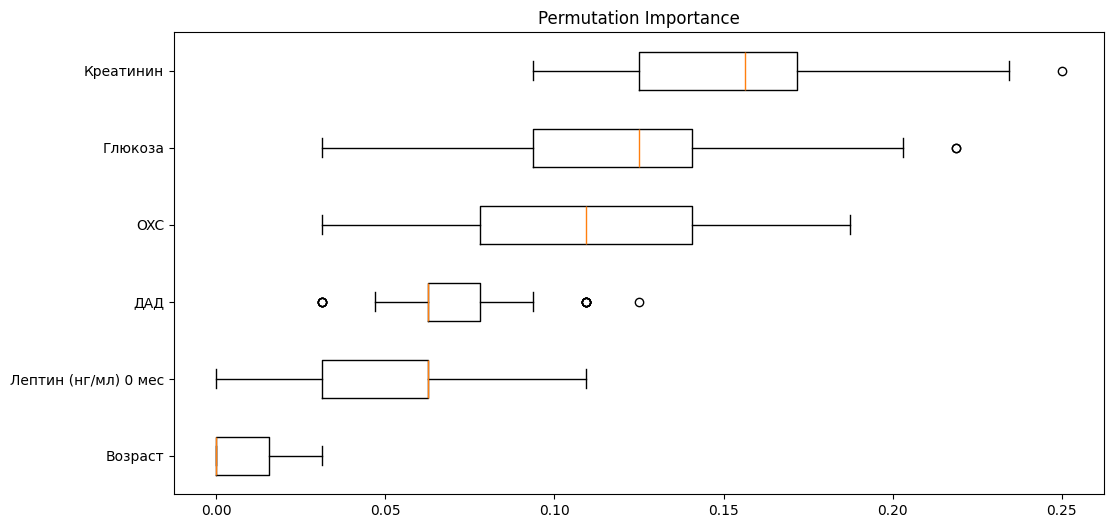

TypeError: only integer scalar arrays can be converted to a scalar index

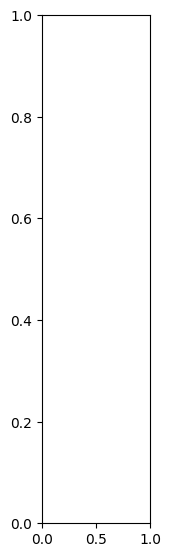

In [16]:
dt = Dataset(dataset_path="data/dataset_september.xlsx")
dt.preprocess(agroup_params_only=True)
params_good = ["OXC", "ДАД", "Возраст", "Лептин (нг/мл) 0 мес", "Креатинин", "Глюкоза"]
X, y = dt.get_X_y("SIB", [5, 10], params=params_good)
model, X, y_true, y_pred = classification_experiment(XGBClassifier(), X, y, use_pipeline=False)
experiment_logger(model, X, y_true, y_pred)



              precision    recall  f1-score   support

           0       0.65      0.80      0.71        44
           1       0.50      0.44      0.47        25
           2       0.33      0.10      0.15        10

    accuracy                           0.59        79
   macro avg       0.49      0.45      0.45        79
weighted avg       0.56      0.59      0.57        79





,0,1
1,ДАД,0.2387
0,OXC,0.1933
5,Глюкоза,0.1740
3,Лептин (нг/мл) 0 мес,0.1680
4,Креатинин,0.1177
2,Возраст,0.1083


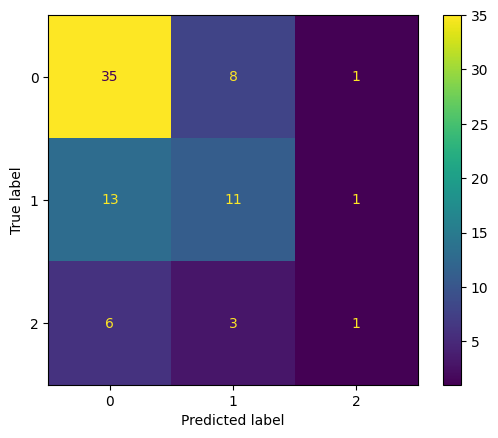

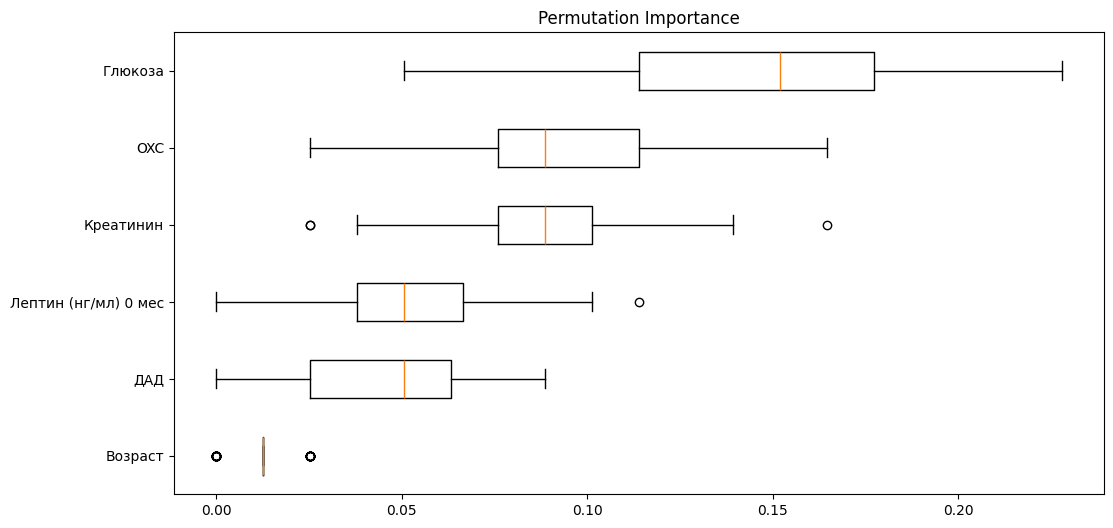

TypeError: only integer scalar arrays can be converted to a scalar index

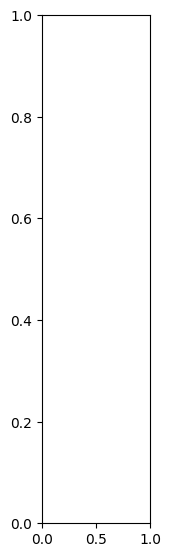

In [17]:
dt = Dataset(dataset_path="data/dataset_almazov_november.xlsx")
dt.preprocess(agroup_params_only=True)
params_good = ["OXC", "ДАД", "Возраст", "Лептин (нг/мл) 0 мес", "Креатинин", "Глюкоза"]
X, y = dt.get_X_y("SIB", [5, 10], params=params_good)
model, X, y_true, y_pred = classification_experiment(XGBClassifier(), X, y, use_pipeline=False)
experiment_logger(model, X, y_true, y_pred)

### scientific params



              precision    recall  f1-score   support

           0       0.60      0.72      0.66        36
           1       0.35      0.30      0.32        20
           2       0.00      0.00      0.00         8

    accuracy                           0.50        64
   macro avg       0.32      0.34      0.33        64
weighted avg       0.45      0.50      0.47        64





,0,1
3,Лептин (нг/мл) 0 мес,0.2176
1,ДАД,0.2001
5,Глюкоза,0.1789
4,Креатинин,0.1771
0,OXC,0.1739
2,Возраст,0.0523


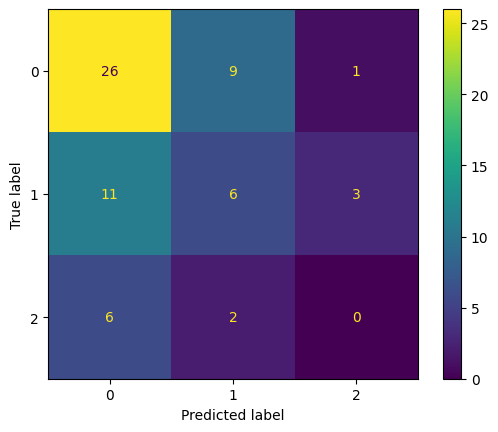

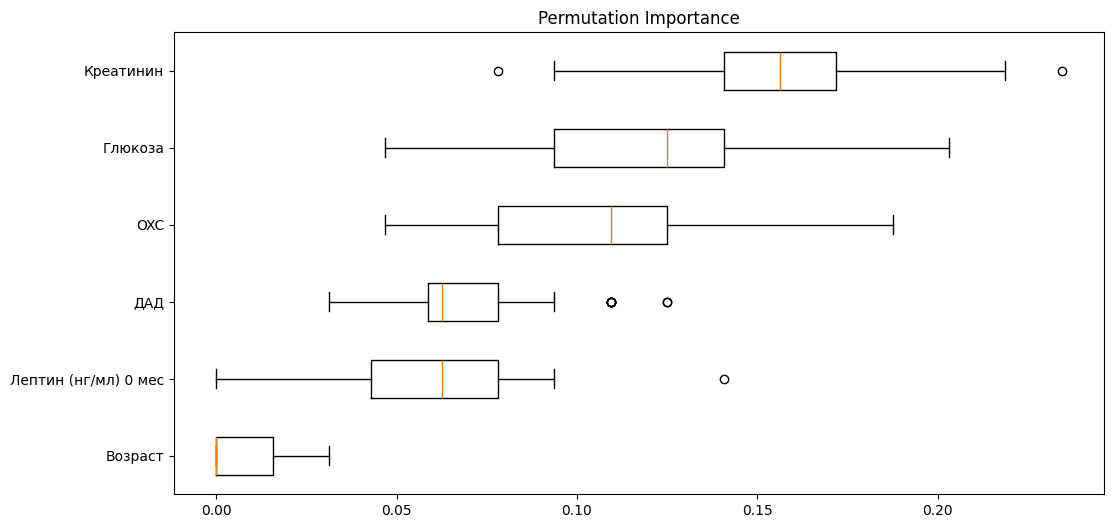

TypeError: only integer scalar arrays can be converted to a scalar index

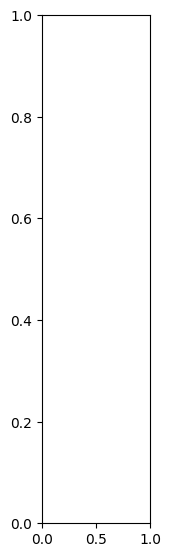

In [18]:
dt = Dataset(dataset_path="data/dataset_september.xlsx")
dt.preprocess(agroup_params_only=True)
params_good = ["OXC", "ДАД", "Возраст", "Лептин (нг/мл) 0 мес", "Креатинин", "Глюкоза"]
X, y = dt.get_X_y("SIB", 5, params=params_good)
model, X, y_true, y_pred = classification_experiment(XGBClassifier(), X, y, use_pipeline=False)
experiment_logger(model, X, y_true, y_pred)



              precision    recall  f1-score   support

           0       0.60      0.72      0.66        36
           1       0.35      0.30      0.32        20
           2       0.00      0.00      0.00         8

    accuracy                           0.50        64
   macro avg       0.32      0.34      0.33        64
weighted avg       0.45      0.50      0.47        64





,0,1
3,Лептин (нг/мл) 0 мес,0.2176
1,ДАД,0.2001
5,Глюкоза,0.1789
4,Креатинин,0.1771
0,OXC,0.1739
2,Возраст,0.0523


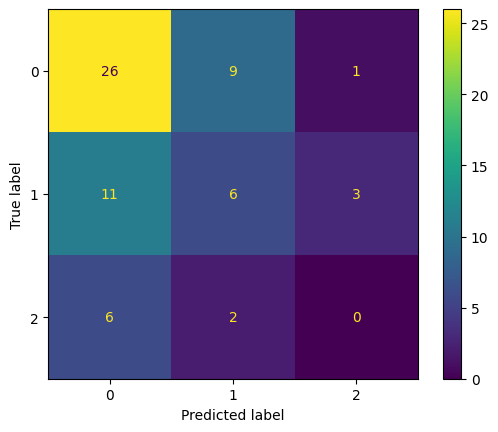

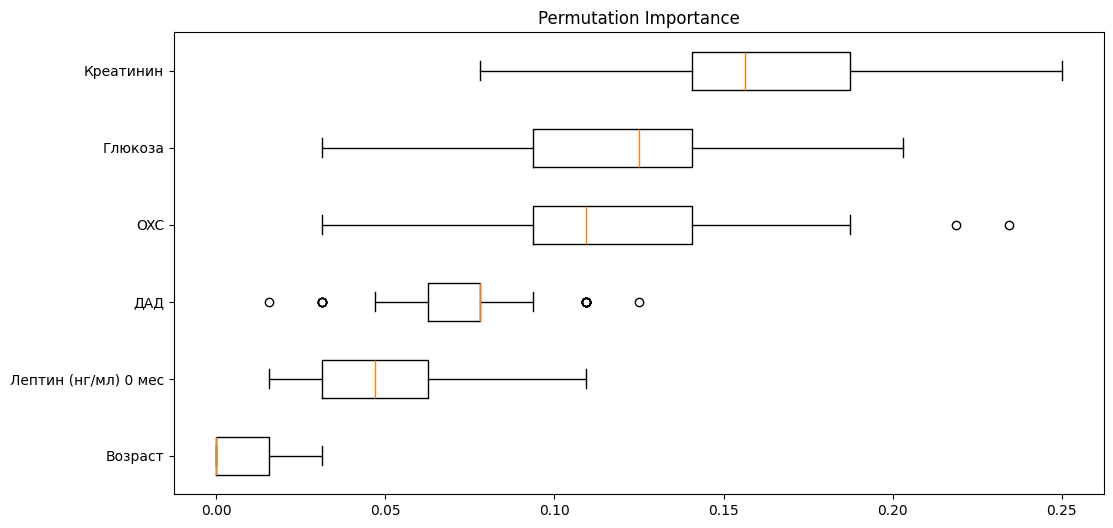

TypeError: only integer scalar arrays can be converted to a scalar index

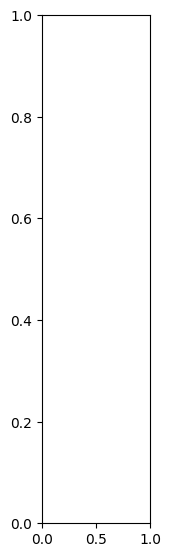

In [29]:
params_good = ["OXC", "ДАД", "Возраст", "Лептин (нг/мл) 0 мес", "Креатинин", "Глюкоза"]
X, y = dt.get_X_y("SIB", [5, 10], params=params_good)
model, X, y_true, y_pred = classification_experiment(XGBClassifier(), X, y, use_pipeline=False)
experiment_logger(model, X, y_true, y_pred)

In [30]:
print(classification_report(y_test, model.predict(X_test)))
get_predictions_with_confidence(model, X_test, y_test, True)

              precision    recall  f1-score   support

           0       0.67      0.67      0.67         9
           1       0.67      0.33      0.44         6
           2       0.00      0.00      0.00         0

    accuracy                           0.53        15
   macro avg       0.44      0.33      0.37        15
weighted avg       0.67      0.53      0.58        15



,Real,Predicted,Confidence
0,5% - 10%,less 5%,[0.76 0.22 0.02]
1,5% - 10%,less 5%,[0.96 0.02 0.02]
2,5% - 10%,5% - 10%,[0.02 0.94 0.04]
3,less 5%,less 5%,[0.6 0.36 0.04]
4,5% - 10%,more 10%,[0.08 0.28 0.64]
5,less 5%,5% - 10%,[0.31 0.4 0.29]
6,less 5%,more 10%,[0.14 0.23 0.63]
7,less 5%,less 5%,[0.97 0.01 0.02]
8,less 5%,less 5%,[0.83 0.03 0.14]
9,5% - 10%,less 5%,[0.9 0.09 0.01]


### Feature Elimination

In [19]:
def recursively_delete_params(model, dt, set_of_params):
  params_to_eliminate = set_of_params.copy()
  stats = []
  while len(params_to_eliminate)>1:
    current_set_of_params = params_to_eliminate.copy()
    X, y = dt.get_X_y("SIB", 5, params=current_set_of_params, target_type="A")
    model, _, y_true, y_pred = classification_experiment(model, X, y)
    statdf = pd.DataFrame(list(zip(params_to_eliminate, model.feature_importances_))).sort_values(by=1, ascending=False)
    statdf = statdf[statdf[1]>0]
    macro_f1 = classification_report(y_true, y_pred, output_dict=True)["macro avg"]["f1-score"]
    stats.append([params_to_eliminate.copy(), macro_f1, len(current_set_of_params)])
    print("Progress: ", len(set_of_params) - len(params_to_eliminate), " / ", len(set_of_params), "F1 score ", macro_f1)
    param_to_remove = statdf.iloc[-1, 0]
    params_to_eliminate.remove(param_to_remove)
  dfstats = pd.DataFrame(stats, columns=["Set of params", "F1", "Count of parameters"])
  dfstats = dfstats.sort_values(by = "F1", ascending=False)
  return dfstats

In [22]:
dt = Dataset(dataset_path="data/dataset_september.xlsx")
dt.preprocess(agroup_params_only=True)
params_test = dt.dataset.columns.values
print(params_test)
recursively_delete_params(XGBClassifier(), dt, params_test)

['Лечение' '% потери веса 3 мес' '% потери веса 6 мес' 'Пол' 'Возраст'
 'Рост' 'Вес 0 мес' 'Вес 3 мес' 'Вес 6 мес' 'ОТ 0 мес' 'ОТ 3 мес'
 'ОТ 6 мес' 'ОБ 0 мес' 'ОБ 3 мес' 'ОБ 6 мес' 'ОТ/ОБ 0 мес' 'ОТ/ОБ 3 мес'
 'ОТ/ОБ 6 мес' 'ИМТ 0 мес' 'ИМТ 3 мес' 'ИМТ 6 мес'
 'Индекс Висцерального Ожирения (ИВО)'
 'Накопление липидных продуктов (LAP)' 'Отношение ОТ к росту'
 'Индекс конусности (ИК)' 'Нарушение толерантности к глюкозе (НТГ)'
 'Артериальная гипертензия' 'Дислипидемия' 'Фенотип ожирения'
 'Стаж ожирения' 'Степень ожирения' 'МЗО=0/МНО=1'
 'МЗО=0/МНО=1 V2 (НОМА >2,7)' 'МЗО=0/МНО=1 V3 (Мейгц)'
 'Концентрическая гипертрофия' 'Уровень NT-proBMP' 'Кардиогруппа'
 'Лептинрезистентность' 'И-АПФ' 'Сартаны' 'В-Блокаторы' 'Са-блокаторы'
 'Диуретики' 'Статины' 'САД' 'ДАД' 'Пульс' 'Глюкоза' 'Инсулин' 'HOMA-IR'
 'HOMA-B' 'OXC' 'ЛПВП' 'ЛПНП' 'ЛПОНП 0 мес' 'ТГ' 'КА' 'Креатинин' 'СКФ'
 'Мочевая Кислота' 'СРБ' 'Лептин (нг/мл) 0 мес'
 'Лептин 1 час (нг/мл) 0 мес' 'Адипонектин (мкг/мл) 0 мес'
 'Лептин/Адипо

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
t = []
sdpl_copy = sib_default_params_list.copy()
for i in range(5):
  sibstatsdf = recursively_delete_params("SIB", sdpl_copy)
  best_param = sibstatsdf[sibstatsdf["Count of parameters"]==1]["Set of params"].iloc[0][0]
  sdpl_copy.remove(best_param)
  t.append(best_param)
print(t)

['Инсулин', 'СРБ', 'HOMA-B', 'ЛПВП', 'индекс конусности ИК= ОТ(м)/0,109×√(рост(м)/вес (кг) 0 мес']




              precision    recall  f1-score   support

           0       0.70      0.77      0.73        43
           1       0.69      0.61      0.65        36

    accuracy                           0.70        79
   macro avg       0.69      0.69      0.69        79
weighted avg       0.70      0.70      0.69        79



,0,1
1,СРБ,0.2522
4,Лептин 1 час (нг/мл) 0 мес,0.1678
3,miR142 (ПЛАЗМА) 0 мес,0.1668
5,Инсулин,0.1492
0,"параксоназа мкг/мл (0,56-8,2) 0 мес",0.1363
2,Грелин 1 час (нг/мл) 0 мес.1,0.1278


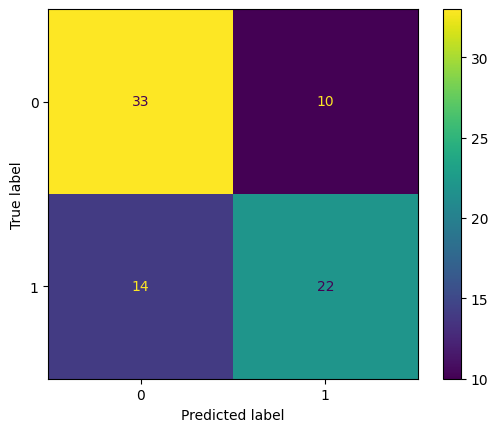

In [ ]:
model_sib, X, y_true, y_pred = classification_experiment(RandomForestClassifier(), medicine="SIB",
        params = ['параксоназа мкг/мл (0,56-8,2) 0 мес',
                  'СРБ',
                  'Грелин 1 час (нг/мл) 0 мес.1',
                  'miR142 (ПЛАЗМА) 0 мес',
                  'Лептин 1 час (нг/мл) 0 мес',
                  'Инсулин'], target_type="C")
statdf = pd.DataFrame(list(zip(model_sib[:-1].get_feature_names_out(), model_sib[-1].feature_importances_))).sort_values(by=1, ascending=False)
statdf = statdf[statdf[1]>0]
print("\n")
print(classification_report(y_true, y_pred))
display(statdf)
ConfusionMatrixDisplay.from_predictions(y_true, y_pred)

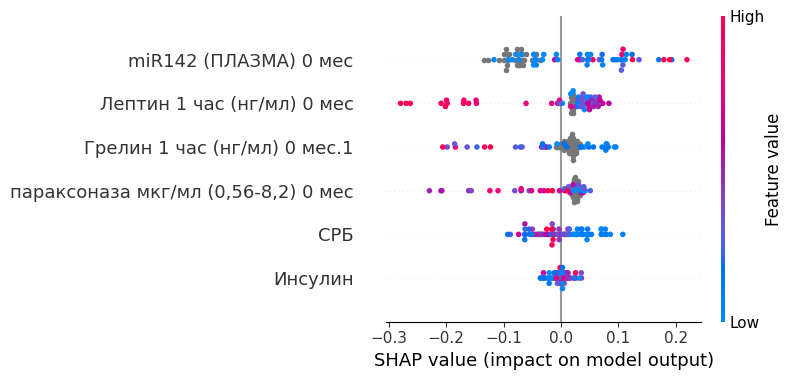

In [ ]:
explainer = shap.TreeExplainer(model[-1], X)
shap_values = explainer(X)
shap.summary_plot(shap_values[:, :, 1],X)

### SAX

In [ ]:
t = []
sdpl_copy = sax_default_params_list.copy()
for i in range(5):
  saxstatsdf = recursively_delete_params("SAX", sdpl_copy)
  best_param = saxstatsdf[saxstatsdf["Count of parameters"]==1]["Set of params"].iloc[0][0]
  sdpl_copy.remove(best_param)
  t.append(best_param)
print(t)


['ГПП 1 нг/мл 0 мес', 'Креатинин мкмоль/л (53-106) 0 мес', 'ТИМ справа ср, мм 0 мес', 'Е-селектин нг/мл 0 мес', 'CCL2 0 мес']




              precision    recall  f1-score   support

           0       0.80      0.67      0.73        12
           1       0.76      0.87      0.81        15

    accuracy                           0.78        27
   macro avg       0.78      0.77      0.77        27
weighted avg       0.78      0.78      0.77        27



,0,1
0,HOMA-B,0.2001
3,ЛПНП,0.1930
2,ГПП 1 нг/мл 0 мес,0.1841
5,ИМТ 0 мес,0.1693
4,Креатинин мкмоль/л (53-106) 0 мес,0.1387
1,Пульс,0.1148


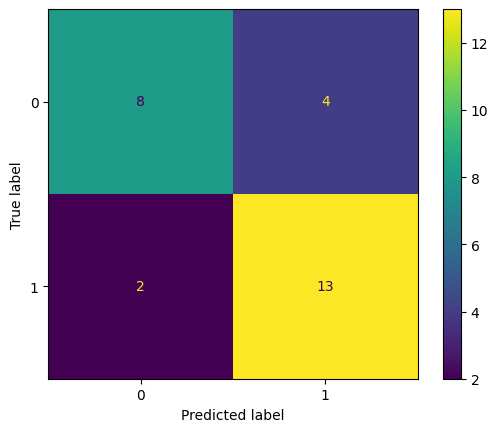

In [ ]:
model_sax, X, y_true, y_pred = classification_experiment(RandomForestClassifier(), medicine="SAX",
        params = ['ГПП 1 нг/мл 0 мес',
                  'Креатинин мкмоль/л (53-106) 0 мес',
                  'HOMA-B', 'ИМТ 0 мес', "Сартаны"], target_type="C")
statdf = pd.DataFrame(list(zip(model[:-1].get_feature_names_out(), model[-1].feature_importances_))).sort_values(by=1, ascending=False)
statdf = statdf[statdf[1]>0]
print("\n")
print(classification_report(y_true, y_pred))
display(statdf)
ConfusionMatrixDisplay.from_predictions(y_true, y_pred)

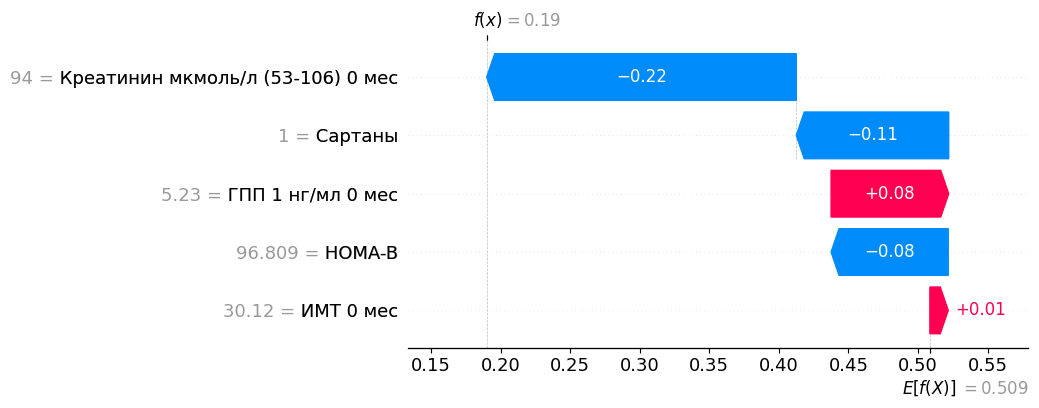

In [ ]:
shap.plots.waterfall(shap_values[7][:, 1])

## CatBoost

In [ ]:
m = catboost.CatBoostClassifier(learning_rate=0.001, iterations=10000)
st = []
dataset_x = some_transforms()
dataset_x = dataset_x[dataset_x["Лечение"]=="SIB"].drop(["Лечение"], 1)
X, y = dataset_x.drop(["% потери веса 3 мес", "% потери веса 6 мес"], 1), ((dataset_x["% потери веса 3 мес"]>=5)|(dataset_x["% потери веса 6 мес"]>=5)).astype(int)
# y = (y-y.min())/(y.max()-y.min())
# X.loc[:, cat_features] = X.loc[:, cat_features].astype(str)
X_train, X_test, y_train, y_test = train_test_split(X, y)
m.fit(X_train, y_train)
m.score(X_test, y_test)

In [ ]:
m = catboost.CatBoostClassifier(learning_rate=0.001, iterations=10000)
st = []
dataset_x = some_transforms()
dataset_x = dataset_x[dataset_x["Лечение"]=="SIB"].drop(["Лечение"], 1)
params = [
    'Адипонектин (мкг/мл) 0 мес',
    'Грелин 1 час (нг/мл) 0 мес.1',
    'miR142 (ПЛАЗМА) 0 мес',
    'Лептин 1 час (нг/мл) 0 мес',
    'ADIPOQ 0 мес',
    'Проколлаген 1 типа нг/мл (183-244) 0 мес'
]
X, y = dataset_x.drop(["% потери веса 3 мес", "% потери веса 6 мес"], 1)[params], ((dataset_x["% потери веса 3 мес"]>=5)|(dataset_x["% потери веса 6 мес"]>=5)).astype(int)
m.fit(X, y)

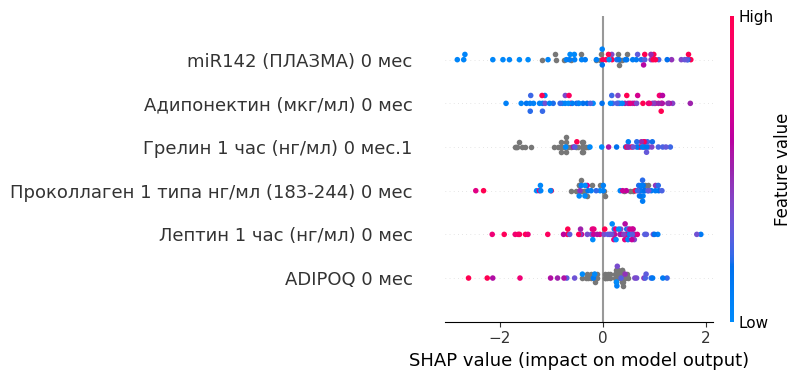

In [ ]:
# shap_values = m.get_feature_importance(Pool(X, y), type='ShapValues')
# expected_value = shap_values[0,-1]
# shap_values = shap_values[:,:-1]
# shap.summary_plot(shap_values, X)

## Тестирование модели на новых данных

In [ ]:
test_dataset_path = "data/dataset_almazov_november.xlsx"
if (not os.path.exists(test_dataset_path)):
  !gdown 1mYU2x0NhbIhmuCYAKPSP3Q9345sPlAC1 -O dataset_almazov_november.xlsx
test_dataset = pd.read_excel(test_dataset_path)
test_dataset = test_dataset.loc[125:, :]
test_dataset

,ID,"Пол 0 - М, 1 - Ж","Выполняли ли ПЭТ 0- нет, 1 - да","Наличие БЖТ исходно по ПЭТ 0 -нет, 1 - да","Наличие БЖТ через 6 мес по ПЭТ 0 -нет, 1 - да",Возраст,Рост,Вес 0 мес,Вес 3 мес,Вес 6 мес,...,Ограничительное (Диетическое) пищевое поведение В2.,Насколько голодным вы себя чувствуете? В2.,Насколько сытым вы себя чувствуете? В2.,Насколько сильно вы хотите есть? В2.,Сколько пищи вы могли бы сейчас съесть? В2.,Никотин В2.,Алкоголь В2.,EQ-5 В2.,Депрессия В1..1,Тревога В2.
125,SIB2-01,0,1,0.0000,NaN,25,180,134.0000,119.0000,126.0000,...,4.4000,5.0000,5.0000,2.0000,2.0000,NaN,NaN,80.0000,1.0000,4.0000
126,SIB2-02,1,1,0.0000,NaN,45,166,80.0000,76.0000,74.0000,...,2.7000,0.0000,10.0000,0.0000,0.0000,NaN,NaN,50.0000,4.0000,5.0000
127,SIB2-04,1,1,0.0000,0.0000,35,166,113.0000,106.0000,104.0000,...,2.4000,4.0000,4.0000,6.0000,3.0000,NaN,NaN,70.0000,7.0000,9.0000
128,SIB2-05,0,1,0.0000,0.0000,46,180,122.0000,120.0000,119.0000,...,2.0000,6.0000,4.0000,5.0000,4.0000,NaN,NaN,90.0000,10.0000,4.0000
129,SIB2-06,0,0,NaN,NaN,37,171,98.0000,91.0000,87.0000,...,3.7000,7.0000,5.0000,3.0000,4.0000,NaN,NaN,75.0000,4.0000,10.0000
130,SIB2-08,0,1,0.0000,0.0000,42,183,123.0000,120.0000,118.0000,...,3.5000,3.0000,8.0000,4.0000,4.0000,NaN,NaN,50.0000,3.0000,8.0000
131,SIB2-10,1,0,NaN,NaN,46,156,105.0000,101.0000,103.0000,...,2.4000,5.0000,5.0000,6.0000,7.0000,NaN,NaN,55.0000,11.0000,6.0000
132,SIB2-11,1,1,0.0000,0.0000,29,161,102.0000,100.0000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
133,SIB2-12,0,1,0.0000,0.0000,39,186,105.0000,102.0000,101.0000,...,2.6000,5.0000,5.0000,7.0000,3.0000,NaN,NaN,69.0000,5.0000,4.0000
134,SIB2-13,1,0,NaN,NaN,32,157,106.0000,95.0000,88.0000,...,2.6000,5.0000,5.0000,3.0000,4.0000,NaN,NaN,55.0000,8.0000,2.0000


## 3 bins

In [ ]:
def classification_experiment_multi(model, params, medicine="SIB", target_type="C"):
  dataset_x = some_transforms()
  dataset_x = dataset_x[dataset_x["Лечение"]==medicine].drop("Лечение", 1)
  if (target_type == "B"):
    dataset_x = dataset_x[~dataset_x["% потери веса 6 мес"].isna()]

  pipe = Pipeline([
    ("imputer", SimpleImputer()),
    ("regressor", model)
  ])

  cv_loo = LeaveOneOut()
  targetcol_3 = "% потери веса 3 мес"
  targetcol_6 = "% потери веса 6 мес"
  y_3 = dataset_x[targetcol_3]
  y_6 = dataset_x[targetcol_6]
  if (target_type=="A"):
    target = y_3.astype(int).reset_index(drop=True).to_numpy()
  if (target_type=="B"):
    target = y_6.astype(int).reset_index(drop=True).to_numpy()
  if (target_type=="C"):
    target = np.nanmax([y_3, y_6], axis=0)
  target = np.digitize(target, [-10, 5, 10])
  y = target
  X = dataset_x
  if params!=None:
    X = dataset_x[params]
  X = X.loc[:, ~X.isna().all()]
  X = X.reset_index(drop=True)
  for j in [targetcol_3, targetcol_6]:
    if (j in X.columns):
      X = X.drop(j, axis=1)
  y_pred = []
  y_true = []
  for idx, (train_index, test_index) in enumerate(cv_loo.split(X)):
    X_train, X_test, y_train, y_test = X.iloc[train_index, :], \
                                      X.iloc[test_index, :], \
                                      y[train_index], \
                                      y[test_index]
    try:
      pipe.fit(X_train, y_train)
    except:
      raise Exception(str((X_train, y_train)))
    y_pred.append(pipe.predict(X_test))
    y_true.append(y_test[0])
  y_pred = np.array(y_pred).squeeze().tolist()
  y_true = np.array(y_true).squeeze().tolist()
  return pipe, X, y_true, y_pred

In [ ]:
def recursively_delete_params_multi(medicine, set_of_params):
  params_to_eliminate = set_of_params.copy()
  stats = []
  while len(params_to_eliminate)!=0:
    try:
      model, X, y_true, y_pred = classification_experiment_multi(DecisionTreeClassifier(),
                                                                params=params_to_eliminate,
                                                                medicine=medicine,
                                                                target_type="C")
    except:
      break
    statdf = pd.DataFrame(list(zip(model[:-1].get_feature_names_out(), model[-1].feature_importances_))).sort_values(by=1, ascending=False)
    statdf = statdf[statdf[1]>0]
    macro_f1 = classification_report(y_true, y_pred, output_dict=True)["macro avg"]["f1-score"]
    stats.append([params_to_eliminate.copy(), macro_f1, len(params_to_eliminate.copy())])
    param_to_remove = statdf.iloc[-1, 0]
    params_to_eliminate.remove(param_to_remove)
    # print("Progress: ", len(set_of_params) - len(params_to_eliminate), " / ", len(set_of_params), "F score ", macro_f1)
  dfstats = pd.DataFrame(stats, columns=["Set of params", "F1", "Count of parameters"])
  dfstats = dfstats.sort_values(by = "F1", ascending=False)
  return dfstats

In [ ]:
t = []
sdpl_copy = sib_default_params_list.copy()
for i in range(5):
  sibstatsdf = recursively_delete_params_multi("SIB", sdpl_copy)
  best_param = sibstatsdf[sibstatsdf["Count of parameters"]==1]["Set of params"].iloc[0][0]
  sdpl_copy.remove(best_param)
  t.append(best_param)
print(t)

['HOMA-B', 'Глюкоза', 'СРБ', 'ЛПНП', 'Лептин/Адипонектин 0 мес']




              precision    recall  f1-score   support

           1       0.54      0.67      0.59        33
           2       0.35      0.32      0.33        28
           3       0.25      0.17      0.20        18

    accuracy                           0.43        79
   macro avg       0.38      0.38      0.38        79
weighted avg       0.40      0.43      0.41        79



,0,1
1,СРБ,0.2010
5,Инсулин,0.1886
3,miR142 (ПЛАЗМА) 0 мес,0.1701
4,Лептин 1 час (нг/мл) 0 мес,0.1688
0,"параксоназа мкг/мл (0,56-8,2) 0 мес",0.1551
2,Грелин 1 час (нг/мл) 0 мес.1,0.1164


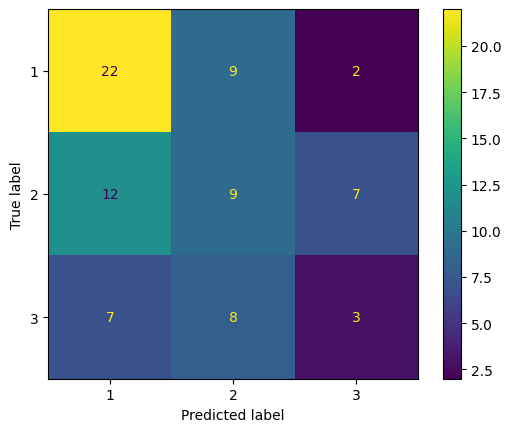

In [ ]:
# model, X, y_true, y_pred = classification_experiment_multi(RandomForestClassifier(), medicine="SIB", params = ['СРБ', 'ЛПНП', 'Лептин/Адипонектин 0 мес', 'Глюкоза', 'OXC'], target_type="C")
model, X, y_true, y_pred = classification_experiment_multi(RandomForestClassifier(), medicine="SIB", params = ['параксоназа мкг/мл (0,56-8,2) 0 мес',
                  'СРБ',
                  'Грелин 1 час (нг/мл) 0 мес.1',
                  'miR142 (ПЛАЗМА) 0 мес',
                  'Лептин 1 час (нг/мл) 0 мес',
                  'Инсулин'], target_type="C")
statdf = pd.DataFrame(list(zip(model[:-1].get_feature_names_out(), model[-1].feature_importances_))).sort_values(by=1, ascending=False)
statdf = statdf[statdf[1]>0]
print("\n")
print(classification_report(y_true, y_pred))
display(statdf)
ConfusionMatrixDisplay.from_predictions(y_true, y_pred)

Text(0.5, 1.0, 'Permutation Importance')

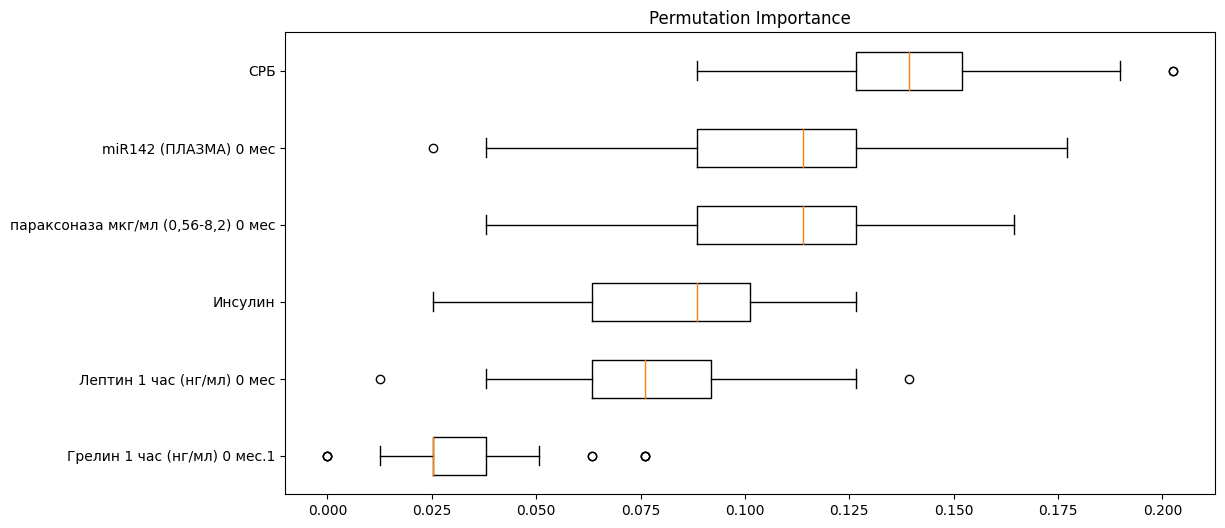

In [ ]:
feature_importance =  model[-1].feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5

fig = plt.figure(figsize=(12, 6))
result = permutation_importance(
    model, X, y_true, n_repeats=100
)
sorted_idx = result.importances_mean.argsort()
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=model[:-1].get_feature_names_out()[sorted_idx],
)
plt.title("Permutation Importance")

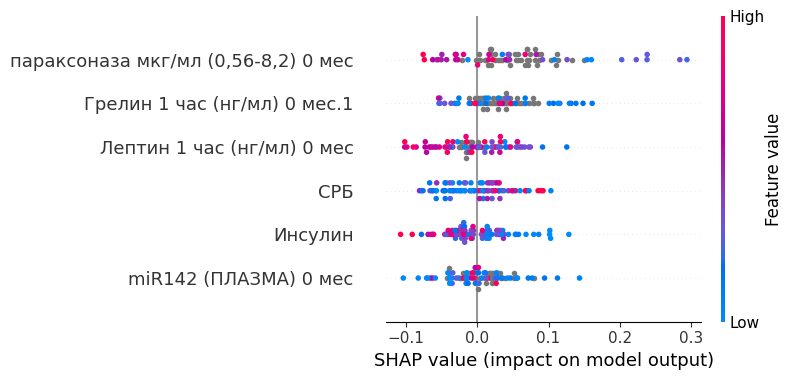

In [ ]:
explainer = shap.TreeExplainer(model[-1])
shap_values = explainer(X)
shap.summary_plot(shap_values[:, :, 1],X)

SAX

In [ ]:
t = []
sdpl_copy = sax_default_params_list.copy()
for i in range(3):
  sibstatsdf = recursively_delete_params_multi("SAX", sdpl_copy)
  best_param = sibstatsdf[sibstatsdf["Count of parameters"]==1]["Set of params"].iloc[0][0]
  sdpl_copy.remove(best_param)
  t.append(best_param)
print(t)

['HOMA-B', 'ГПП 1 нг/мл 0 мес', 'Креатинин мкмоль/л (53-106) 0 мес']




              precision    recall  f1-score   support

           1       0.71      0.83      0.77        12
           2       0.57      0.57      0.57         7
           3       0.67      0.50      0.57         8

    accuracy                           0.67        27
   macro avg       0.65      0.63      0.64        27
weighted avg       0.66      0.67      0.66        27



,0,1
0,HOMA-B,0.2001
3,ЛПНП,0.1930
2,ГПП 1 нг/мл 0 мес,0.1841
5,ИМТ 0 мес,0.1693
4,Креатинин мкмоль/л (53-106) 0 мес,0.1387
1,Пульс,0.1148


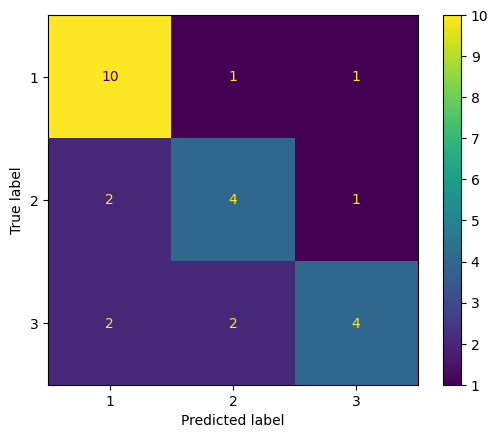

In [ ]:
model, X, y_true, y_pred = classification_experiment_multi(RandomForestClassifier(), medicine="SAX",
        params = ['HOMA-B', 'Пульс', 'ГПП 1 нг/мл 0 мес', 'ЛПНП', 'Креатинин мкмоль/л (53-106) 0 мес', 'ИМТ 0 мес'], target_type="C")
statdf = pd.DataFrame(list(zip(model[:-1].get_feature_names_out(), model[-1].feature_importances_))).sort_values(by=1, ascending=False)
statdf = statdf[statdf[1]>0]
print("\n")
print(classification_report(y_true, y_pred))
display(statdf)
ConfusionMatrixDisplay.from_predictions(y_true, y_pred)

Text(0.5, 1.0, 'Permutation Importance')

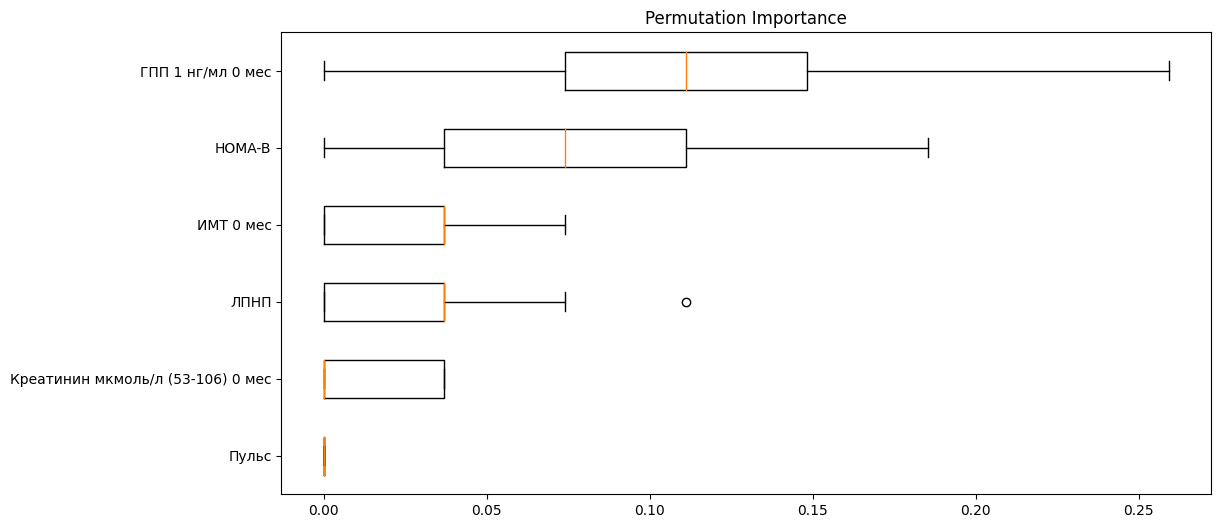

In [ ]:
feature_importance =  model[-1].feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5

fig = plt.figure(figsize=(12, 6))
result = permutation_importance(
    model, X, y_true, n_repeats=100
)
sorted_idx = result.importances_mean.argsort()
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=model[:-1].get_feature_names_out()[sorted_idx],
)
plt.title("Permutation Importance")

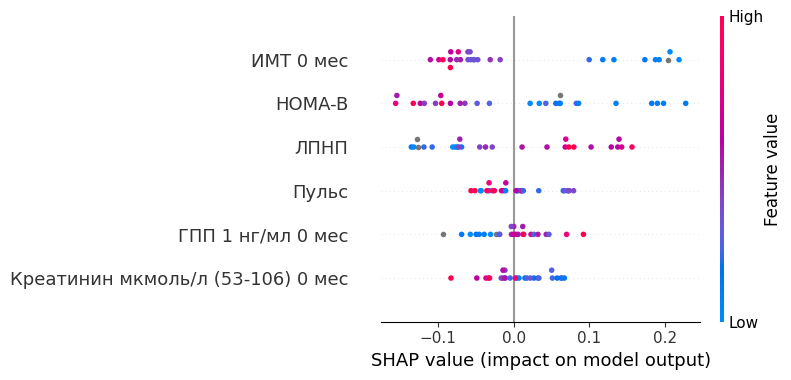

In [ ]:
explainer = shap.TreeExplainer(model[-1])
shap_values = explainer(X)
shap.summary_plot(shap_values[:, :, 1],X)

## Fedot

In [ ]:
!pip install fedot

In [ ]:
import logging
import fedot

In [ ]:
default_predictors = list(filter(lambda x: x not in targets, agroup_parameters)) # список предикторов
def validate_model_fedot(pipe_super, dataset, target="% потери веса 3 мес"):
  target = "% потери веса 3 мес"
  np.random.seed(42)

  # cv
  cv_loo = LeaveOneOut()
  X = dataset.drop(columns=target)
  y = dataset[target]
  y_pred = []
  for idx, (train_index, test_index) in enumerate(cv_loo.split(dataset)):

    X_train, X_test, y_train, y_test = X.iloc[train_index, :], \
                                      X.iloc[test_index, :], \
                                      y[train_index], \
                                      y[test_index]
    data_fedot_train =
    pipe_super.unfit()
    pipe_super.fit(X_train, y_train)
    y_pred.append(pipe_super.predict(X_test))

  # intervals
  y, y_pred = np.array(y).squeeze(), np.array(y_pred).squeeze()
  mse = (y - y_pred) ** 2
  mae = np.abs(y - y_pred)
  r2 = ((y-y_pred)**2)/((y-np.mean(y))**2)
  print(r2)
  l_mse, r_mse = norm.interval(alpha=0.95, loc=np.mean(mse), scale=np.std(mse))
  l_mae, r_mae = norm.interval(alpha=0.95, loc=np.mean(mae), scale=np.std(mae))
  l_r2, r_r2 = norm.interval(alpha=0.95, loc=np.mean(r2), scale=np.std(r2))

  # binary metrics
  y_label = (y>5).astype(np.int64).squeeze()
  y_pred_label = (y_pred>5).astype(np.int64).squeeze()
  try:
    model_name = pipe_super["regressor"].__class__.__name__
  except:
    try:
      model_name = str(pipe_super)
    except:
      model_name = "Undefined"
  return {
      "model": model_name,
      "date": datetime.now().strftime("%H:%M %d/%m/%y"),
      "r2": r2_score(y, y_pred),
      "interval_explained_variance": (l_r2, r_r2),
      "mae": mean_absolute_error(y, y_pred),
      "interval_mae": (round(max(0, l_mae), 2), round(r_mae, 2)),
      "rmse": mean_squared_error(y, y_pred, squared=False),
      "interval_rmse": (round(max(0, np.sqrt(l_mse)), 2), round(np.sqrt(r_mse), 2)),
      "accuracy": accuracy_score(y_label, y_pred_label),
      "precision": precision_score(y_label, y_pred_label),
      "recall": precision_score(y_label, y_pred_label),
      "rocAUC": roc_auc_score(y_label, y_pred_label),
      "f1": f1_score(y_label, y_pred_label)
  }

In [ ]:
dataset_x = some_transforms()
dataset_x = dataset_x[dataset_x["Лечение"]=='SIB'].drop("Лечение", 1)
targetcol_3 = "% потери веса 3 мес"
targetcol_6 = "% потери веса 6 мес"
y_3 = dataset_x[targetcol_3]
y_6 = dataset_x[targetcol_6]
target = (np.nanmax([y_3, y_6], axis=0).round()>=treshold).astype(int)
y = target

X = dataset_x.drop([targetcol_3, targetcol_6], axis=1)
X = X.loc[:, ~X.isna().all()]
X = X.reset_index(drop=True)


NameError: ignored

In [ ]:
fedot_solver = Fedot(problem="regression", timeout=1, preset='fast_train', n_jobs=-1, logging_level=logging.FATAL)
result = fedot_solver.fit(X, y)

NameError: ignored

In [ ]:
validate_model_fedot(result, dataset, target="% потери веса 3 мес")

In [ ]:
if fedot_solver.history and fedot_solver.history.generations:
    print(fedot_solver.history.get_leaderboard())

fedot_solver.current_pipeline.show()

In [ ]:
X_test = X.iloc[:6, :]
y_test = y[:6]
X_test.drop(columns=[target], inplace=True)
X_test

In [ ]:
fedot_solver.predict(X_test)
metrics = fedot_solver.get_metrics()

In [ ]:
fedot_solver.predict(X_test)

In [ ]:
X_test[target]

In [ ]:
metrics

## Economical efficancy

In [ ]:
target_type="C"
dataset_x = some_transforms()
dataset_x = dataset_x[dataset_x["Лечение"].isin(["SIB", "SAX"])]
treatment = dataset_x["Лечение"]
dataset_x = dataset_x.drop("Лечение", 1)

pipe_sib = Pipeline([
  ("imputer", SimpleImputer()),
  ("regressor", RandomForestClassifier())
])

pipe_sax = Pipeline([
  ("imputer", SimpleImputer()),
  ("regressor", RandomForestClassifier())
])

cv_loo = LeaveOneOut()
targetcol_3 = "% потери веса 3 мес"
targetcol_6 = "% потери веса 6 мес"
y_3 = dataset_x[targetcol_3]
y_6 = dataset_x[targetcol_6]
treshold = 5
target = (np.nanmax([y_3, y_6], axis=0).astype(int)>treshold).astype(int)
y = target
X = dataset_x
sib_params = ['параксоназа мкг/мл (0,56-8,2) 0 мес',
                  'СРБ',
                  'Грелин 1 час (нг/мл) 0 мес.1',
                  'miR142 (ПЛАЗМА) 0 мес',
                  'Лептин 1 час (нг/мл) 0 мес',
                  'Инсулин']

sax_params = ['ГПП 1 нг/мл 0 мес',
                  'Креатинин мкмоль/л (53-106) 0 мес',
                  'HOMA-B', 'ИМТ 0 мес', "Сартаны"]

X = X.loc[:, ~X.isna().all()]
X = X.reset_index(drop=True)
for j in [targetcol_3, targetcol_6]:
  if (j in X.columns):
    X = X.drop(j, axis=1)
y_pred = []
y_true = []
print(X.shape, y.shape)
for idx, (train_index, test_index) in enumerate(cv_loo.split(X)):
  X_train, X_test, y_train, y_test = X.iloc[train_index, :], \
                                    X.iloc[test_index, :], \
                                    y[train_index], \
                                    y[test_index]
  print()
  patient_treatment = treatment[idx]
  if (patient_treatment == "SIB"):
    model = pipe_sib
  else:
    model = pipe_sax
  model.fit(X_train, y_train)
  y_pred.append(pipe.predict(X_test))
  y_true.append(y_test[0])
  break
y_pred = np.array(y_pred).squeeze()

(106, 169) (106,)



In [ ]:
def sppr_test(idx, X_input, y_input, treatment):
  X = X_input.copy()
  y = y_input.copy()
  test_sample = X.loc[idx]
  test_medicine = treatment.values[idx]
  test_success = y[idx]
  treatment_tmp = treatment.values.copy()

  sib_params = ['параксоназа мкг/мл (0,56-8,2) 0 мес',
                    'СРБ',
                    'Грелин 1 час (нг/мл) 0 мес.1',
                    'miR142 (ПЛАЗМА) 0 мес',
                    'Лептин 1 час (нг/мл) 0 мес',
                    'Инсулин']

  sax_params = ['ГПП 1 нг/мл 0 мес',
                    'Креатинин мкмоль/л (53-106) 0 мес',
                    'HOMA-B', 'ИМТ 0 мес', "Сартаны"]

  tmp_X = X.drop(idx)
  tmp_y = np.delete(y, idx, 0)
  treatment_tmp = np.delete(treatment_tmp, idx, 0)

  model_sib_tmp = Pipeline([
    ("imputer", SimpleImputer()),
    ("regressor", RandomForestClassifier())
  ])
  model_sax_tmp = Pipeline([
    ("imputer", SimpleImputer()),
    ("regressor", RandomForestClassifier())
  ])

  model_sib_tmp.fit(tmp_X.loc[treatment_tmp=="SIB", sib_params], tmp_y[treatment_tmp=="SIB"])
  model_sax_tmp.fit(tmp_X.loc[treatment_tmp=="SAX", sax_params], tmp_y[treatment_tmp=="SAX"])
  sib_solution = model_sib_tmp.predict([test_sample[sib_params]])[0]
  sax_solution = model_sax_tmp.predict([test_sample[sax_params]])[0]
  return test_medicine, test_success, sib_solution, sax_solution

stats = []
for i in range(X.shape[0]):
  stats.append(sppr_test(i, X, y, treatment))

df = pd.DataFrame(stats, columns=["Врач", "Модель - Сибутрамин", "Модель - Саксенда", "Успех"])
df

,Врач,Модель - Сибутрамин,Модель - Саксенда,Успех
0,SIB,0,0,1
1,SIB,1,1,0
2,SIB,1,1,1
3,SIB,1,1,1
4,SIB,0,1,1
...,...,...,...,...
101,SIB,0,0,1
102,SIB,0,0,1
103,SIB,1,1,1
104,SIB,0,1,1


In [ ]:
df[(df.iloc[:, 0]=="SIB") & (df.iloc[:, 1]==0) & (df.iloc[:, 2]==1)].groupby("Успех").count()

,Врач,Модель - Сибутрамин,Модель - Саксенда
Успех,,,
0,3,3,3
1,8,8,8


In [ ]:
df[(df.iloc[:, 0]=="SAX")].groupby("Успех").count()

,Врач,Модель - Сибутрамин,Модель - Саксенда
Успех,,,
0,10,10,10
1,17,17,17


In [ ]:
df[(df.iloc[:, 0]=="SIB")].groupby("Успех").count()

,Врач,Модель - Сибутрамин,Модель - Саксенда
Успех,,,
0,14,14,14
1,65,65,65


In [ ]:
df[(df.iloc[:, 0]=="SAX") & ((df.iloc[:, 1]==1) & (df.iloc[:, 2]==0))].groupby("Успех").count()

,Врач,Модель - Сибутрамин,Модель - Саксенда
Успех,,,
0,2,2,2
1,6,6,6


In [ ]:
df[(df.iloc[:, 0]=="SAX") & ((df.iloc[:, 1]==0) & (df.iloc[:, 2]==1))].groupby("Успех").count()

,Врач,Модель - Сибутрамин,Модель - Саксенда
Успех,,,
0,1,1,1
1,2,2,2


In [ ]:
df[(df.iloc[:, 0]=="SIB") & (df.iloc[:, 1]==1) & (df.iloc[:, 2]==0)].groupby("Успех").count()

,Врач,Модель - Сибутрамин,Модель - Саксенда
Успех,,,
0,3,3,3
1,11,11,11
